# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408942592, available=469318774784, percent=13.2, used=67897872384, free=470866075648, active=646221824, inactive=59939401728, buffers=4354048, cached=1640640512, shared=236498944, slab=1135370240)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [5]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [6]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [7]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [8]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [9]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [10]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [ ]:
from scipy.optimize import minimize_scalar

In [ ]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [5]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [6]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

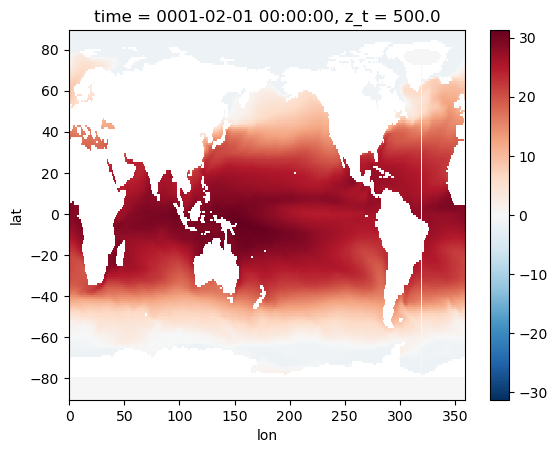

In [7]:
ds_tos.isel(time=0).plot()

## Subset data

In [8]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [9]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

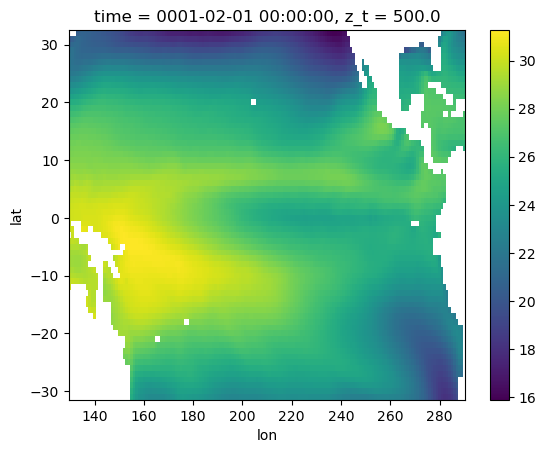

In [10]:
S_tos.isel(time=0).plot()

In [11]:
S_tos

<xarray.DataArray (time: 24000, lat: 64, lon: 161)>
[247296000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 130 131 132 133 134 135 136 ... 285 286 287 288 289 290
  * lat      (lat) float64 -31.0 -30.0 -29.0 -28.0 -27.0 ... 29.0 30.0 31.0 32.0
Attributes:
    regrid_method:  bilinear

In [12]:
del(ds_tos, ds_ssh)

In [13]:
import psutil
psutil.virtual_memory() 

svmem(total=540408942592, available=469101334528, percent=13.2, used=68115300352, free=470648627200, active=646242304, inactive=60156039168, buffers=4354048, cached=1640660992, shared=236503040, slab=1135972352)

## Create matrices, de-trending data and anomalies

In [14]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [16]:
del(S_tos,S_ssh)

In [17]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [18]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [19]:
del(X_ssh)

# 50 years

In [105]:
flabel = {'fontsize':12,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [106]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [107]:
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[6,12,18]

### ALL GAUSS

In [84]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [85]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [30]:
tot_for_union=np.empty((38, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

In [31]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=np.load(f'Forecasts 50/ALLEOFs_forecast_p{n}.npy')[:,:,m,:]

In [87]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [91]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 50/Skill metrics/corr_pattern_50_memb_ALLgauss.nc')
#corr_mean.to_netcdf('Forecasts 50/Skill metrics/corr_pattern_50_mean_ALLgauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


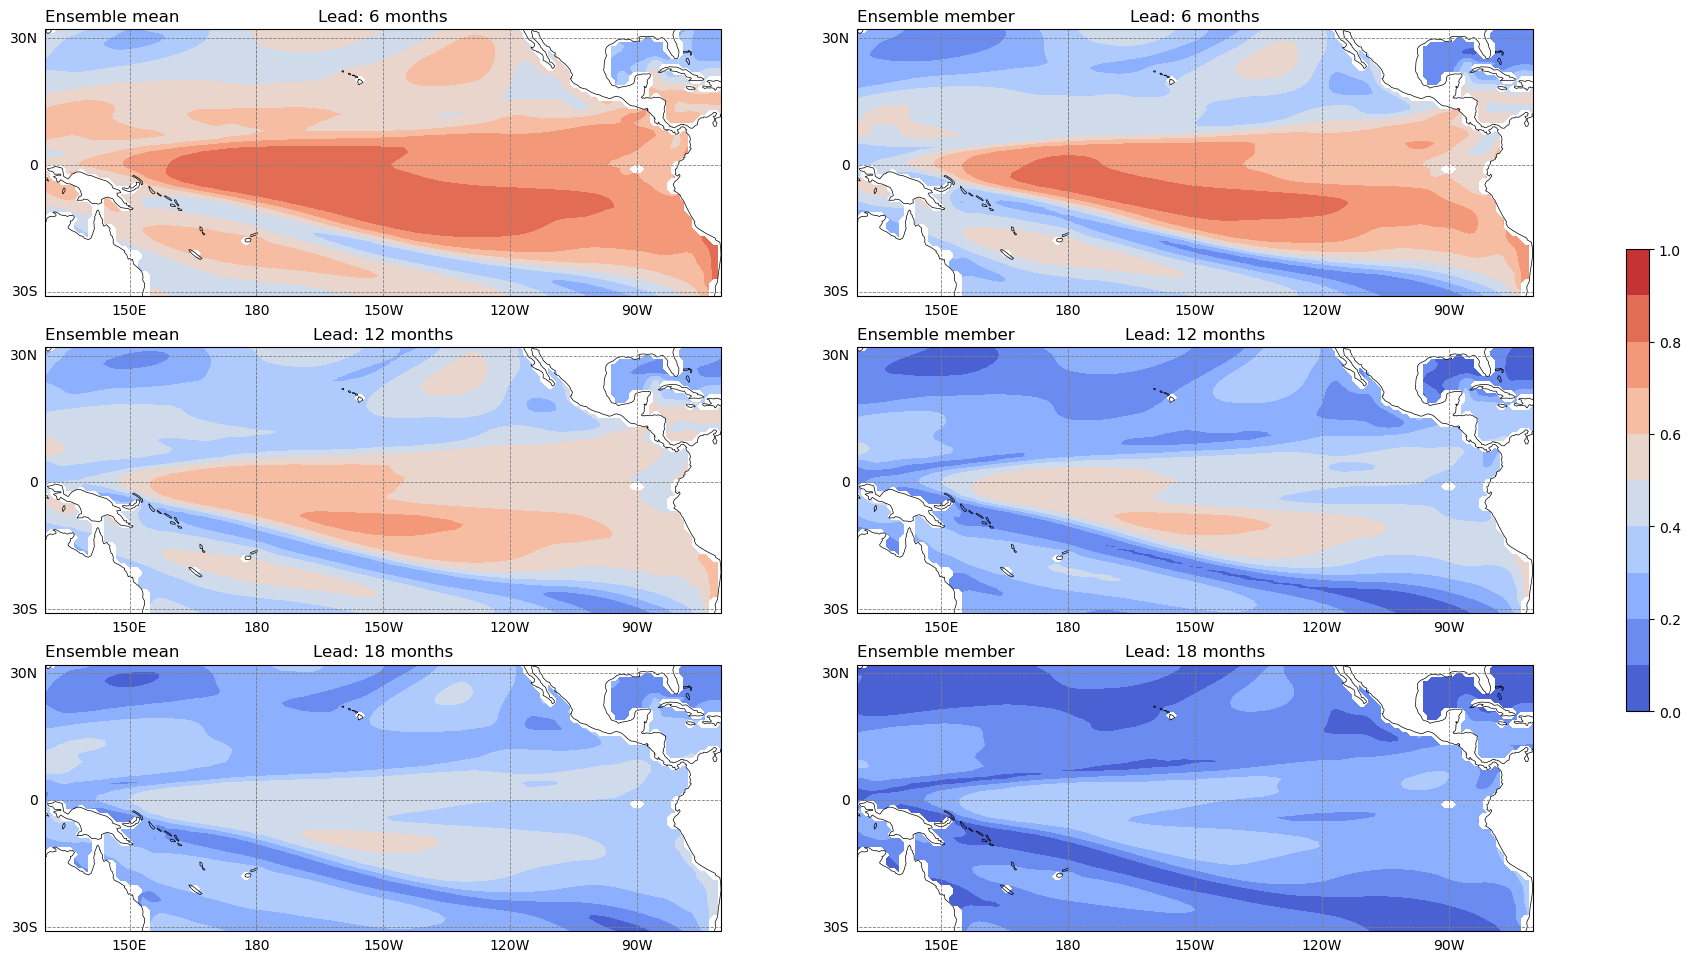

In [30]:
corr_memb=xr.open_dataarray('Forecasts 50/Skill metrics/corr_pattern_50_memb_ALLgauss.nc')
corr_mean=xr.open_dataarray('Forecasts 50/Skill metrics/corr_pattern_50_mean_ALLgauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

### 30 GAUSS

In [108]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [109]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [110]:
tot_for_union=np.empty((38, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [111]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=np.load(f'Forecasts 50/30EOFs_forecast_p{n}.npy')[:,:,m,:]

In [112]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [ ]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 50/Skill metrics/corr_pattern_50_memb_30gauss.nc')
#corr_mean.to_netcdf('Forecasts 50/Skill metrics/corr_pattern_50_mean_30gauss.nc')

In [ ]:
columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

In [ ]:
corr_memb=xr.open_dataarray('Forecasts 50/Skill metrics/corr_pattern_50_memb_30gauss.nc')
corr_mean=xr.open_dataarray('Forecasts 50/Skill metrics/corr_pattern_50_mean_30gauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

### POLY

In [108]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [109]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [110]:
tot_for_union=np.empty((38, 30, 24, 24000))
tot_for_union.fill(np.NaN)

In [ ]:
for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=np.load(f'Forecasts 50/Poly_forecast_p{n}.npy')[:,:,m,:]

In [ ]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [ ]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(38):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 50/Skill metrics/corr_pattern_50_memb_poly.nc')
#corr_mean.to_netcdf('Forecasts 50/Skill metrics/corr_pattern_50_mean_poly.nc')

In [ ]:
columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


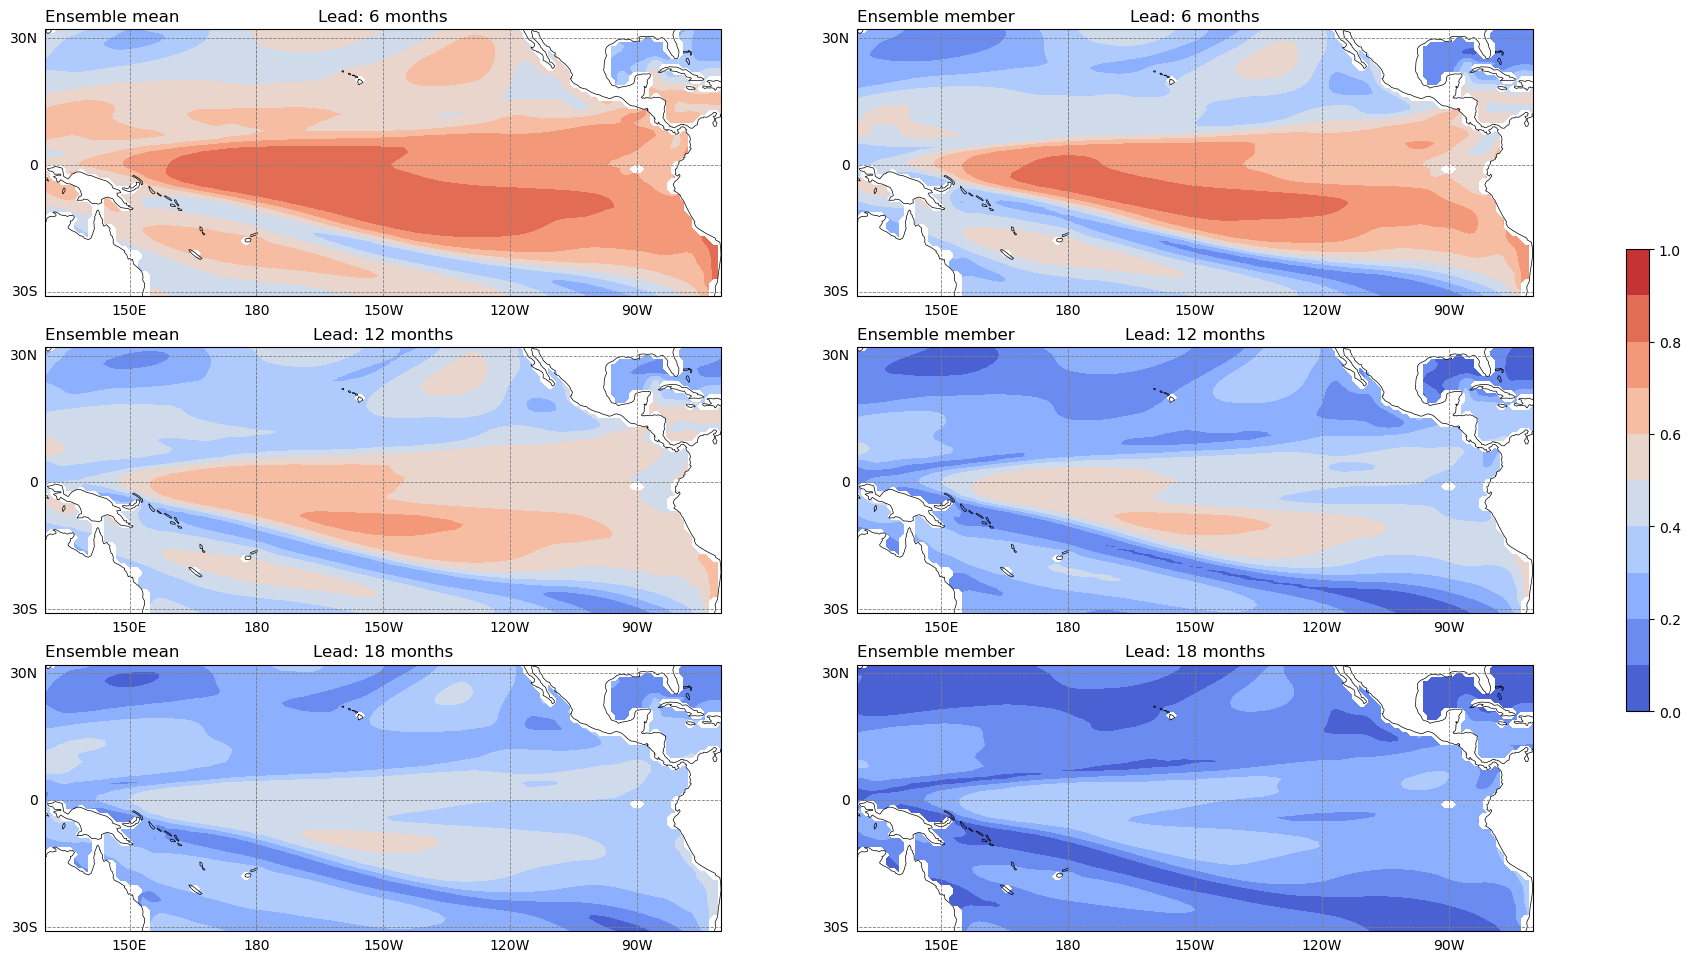

In [30]:
corr_memb=xr.open_dataarray('Forecasts 50/Skill metrics/corr_pattern_50_memb_poly.nc')
corr_mean=xr.open_dataarray('Forecasts 50/Skill metrics/corr_pattern_50_mean_poly.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

# 100 years

In [81]:
flabel = {'fontsize':12,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [82]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [83]:
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[6,12,18]

### ALL GAUSS

In [84]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [85]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [86]:
### Load data

tot_for=np.zeros((20, 19, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((19, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [87]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [91]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 100/Skill metrics/corr_pattern_100_memb_ALLgauss.nc')
#corr_mean.to_netcdf('Forecasts 100/Skill metrics/corr_pattern_100_mean_ALLgauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


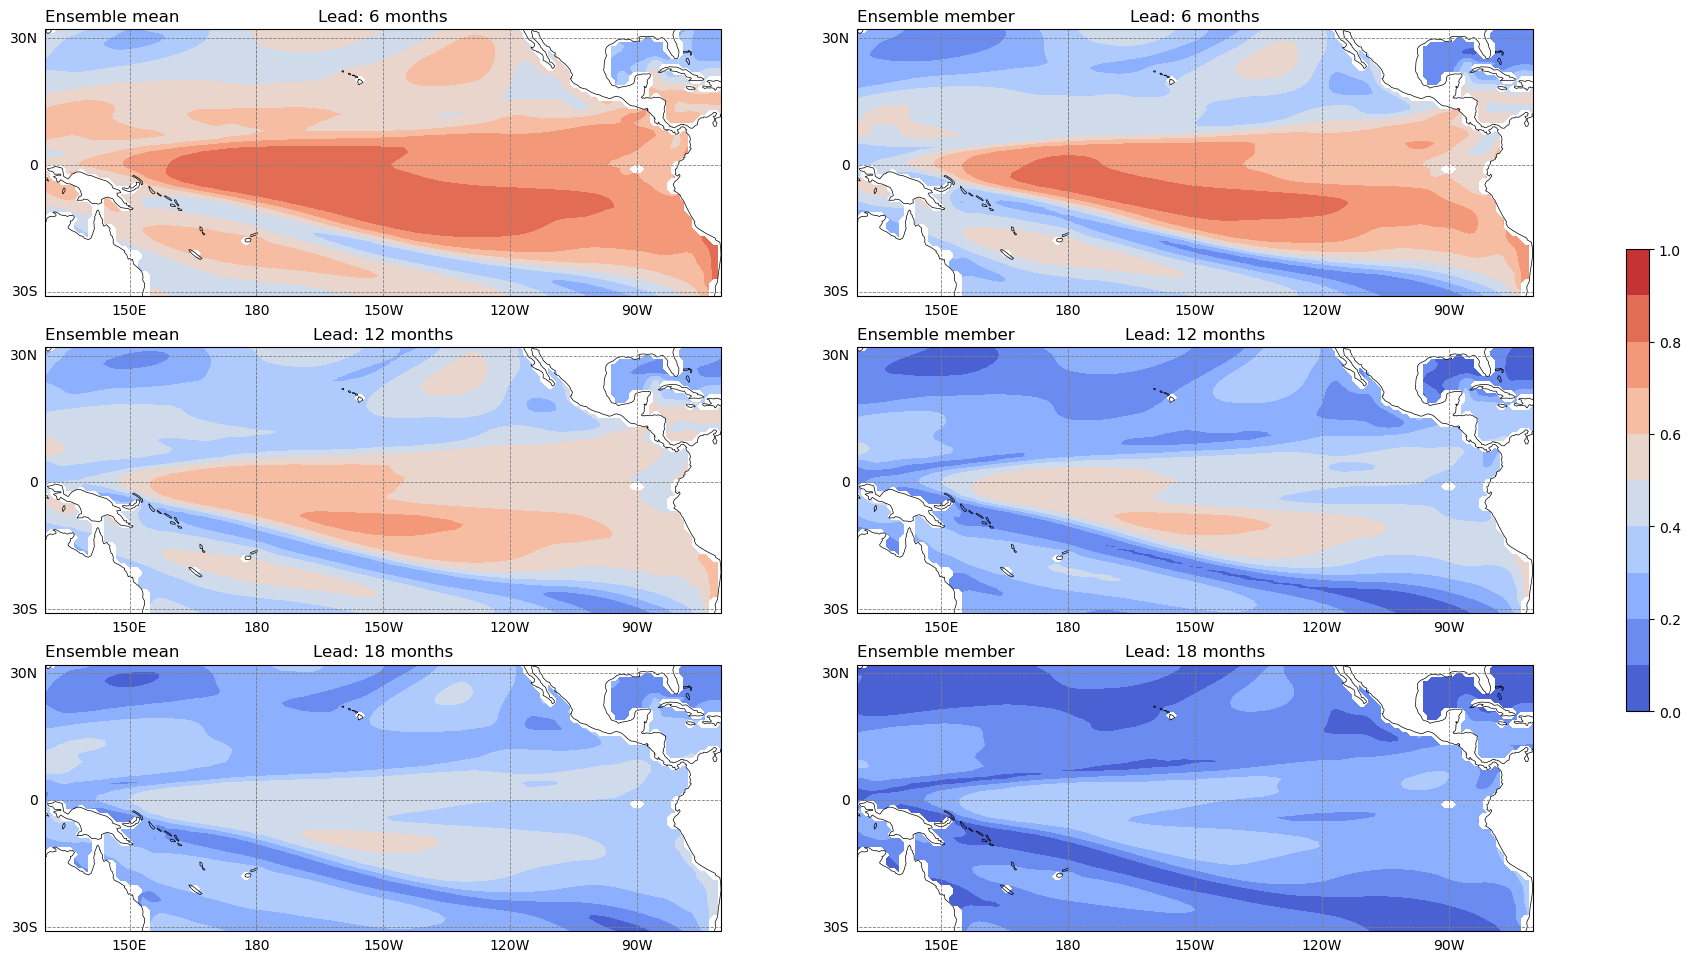

In [30]:
corr_memb=xr.open_dataarray('Forecasts 100/Skill metrics/corr_pattern_100_memb_ALLgauss.nc')
corr_mean=xr.open_dataarray('Forecasts 100/Skill metrics/corr_pattern_100_mean_ALLgauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

### 30 GAUSS

In [84]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [85]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [86]:
### Load data

tot_for=np.zeros((20, 19, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/30EOFs_forecast_p{n}.npy')

tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [87]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [ ]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 100/Skill metrics/corr_pattern_100_memb_30gauss.nc')
#corr_mean.to_netcdf('Forecasts 100/Skill metrics/corr_pattern_100_mean_30gauss.nc')

In [ ]:
columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


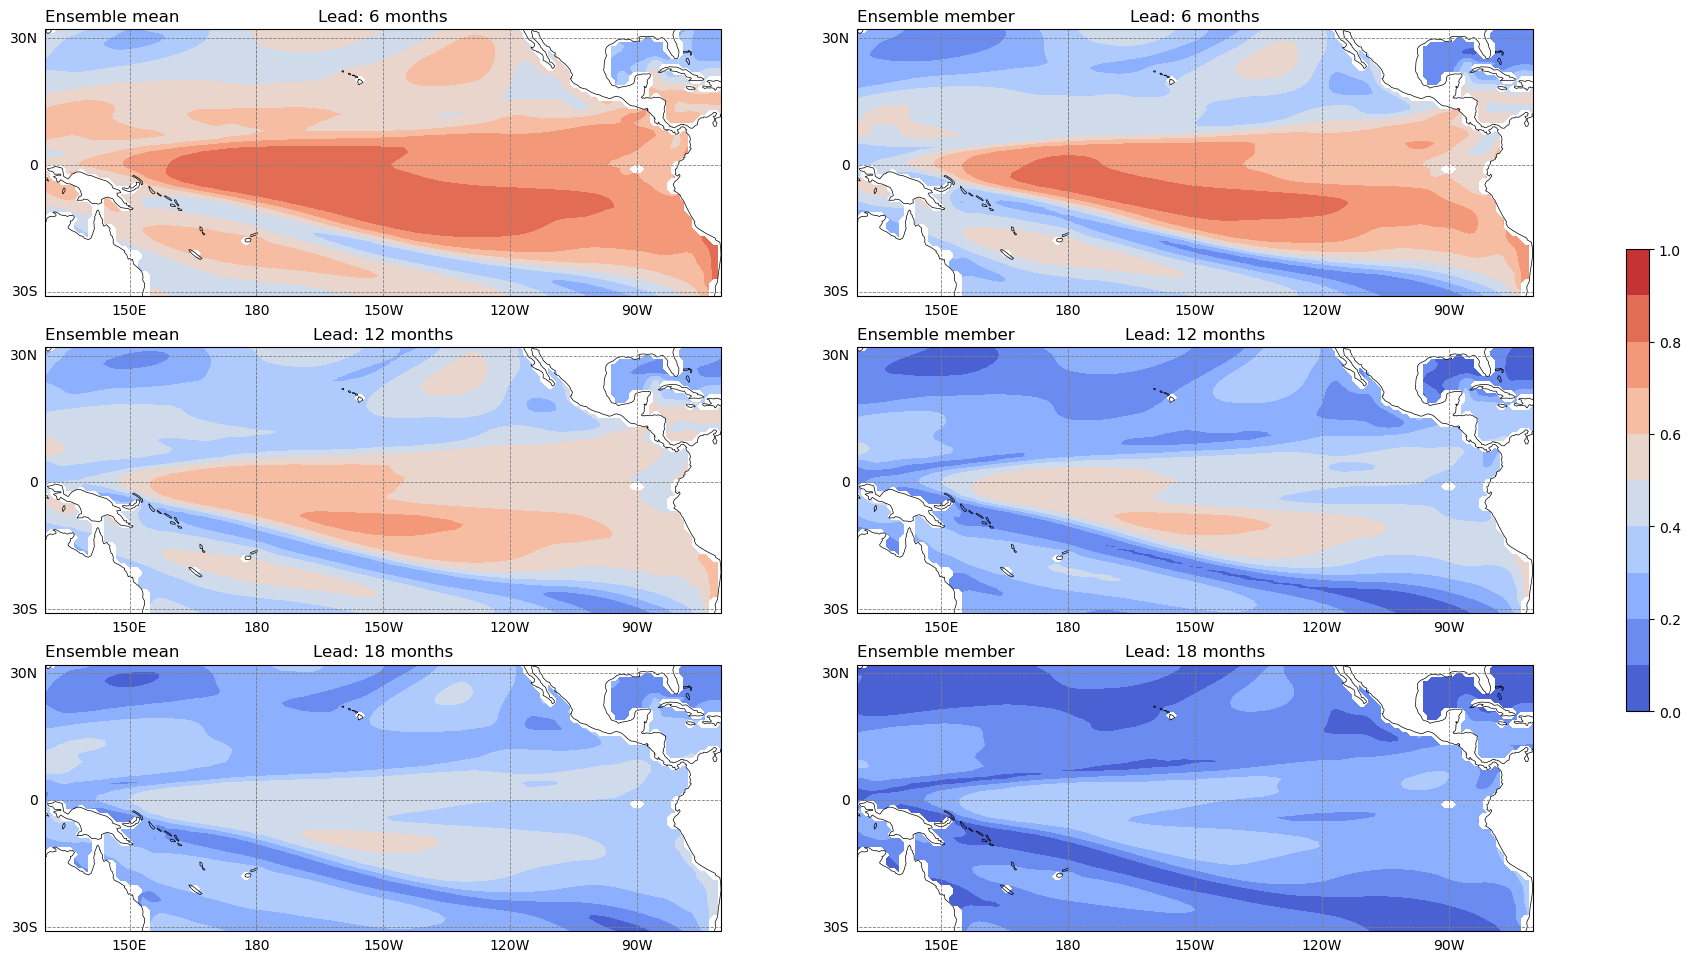

In [30]:
corr_memb=xr.open_dataarray('Forecasts 100/Skill metrics/corr_pattern_100_memb_30gauss.nc')
corr_mean=xr.open_dataarray('Forecasts 100/Skill metrics/corr_pattern_100_mean_30gauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

### POLY

In [84]:
#S### Load data

tot_for=np.zeros((20, 19, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/30EOFs_forecast_p{n}.npy')

tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]]

In [85]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [86]:
### Load data

tot_for=np.zeros((20, 19, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 100/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((19, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [87]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [ ]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 100/Skill metrics/corr_pattern_100_memb_poly.nc')
#corr_mean.to_netcdf('Forecasts 100/Skill metrics/corr_pattern_100_mean_poly.nc')

In [ ]:
columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


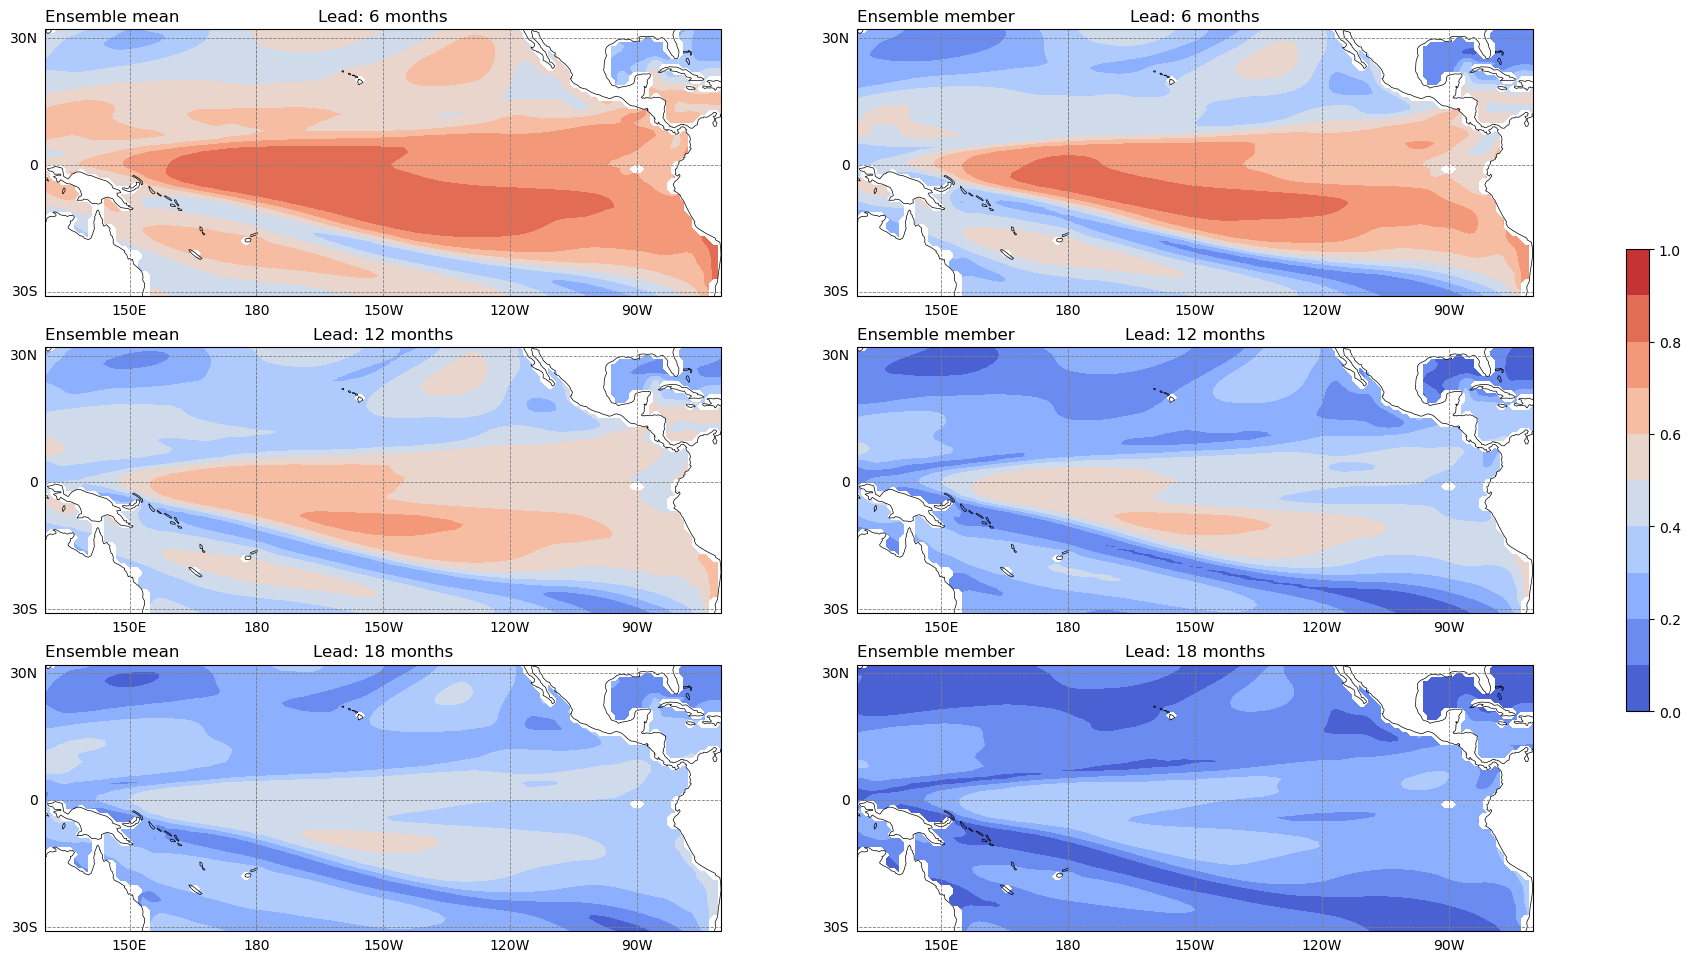

In [30]:
corr_memb=xr.open_dataarray('Forecasts 100/Skill metrics/corr_pattern_100_memb_poly.nc')
corr_mean=xr.open_dataarray('Forecasts 100/Skill metrics/corr_pattern_100_mean_poly.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

# 200 years

In [21]:
flabel = {'fontsize':12,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [22]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [23]:
operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[6,12,18]

### ALL GAUSS

In [24]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [25]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [26]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((17, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [27]:
tot_for_union=tot_for_union[(0,2,4,6,8,10,12,14,16),:,:,:]

In [31]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [102]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 200/Skill metrics/corr_pattern_200_memb_ALLgauss.nc')
#corr_mean.to_netcdf('Forecasts 200/Skill metrics/corr_pattern_200_mean_ALLgauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


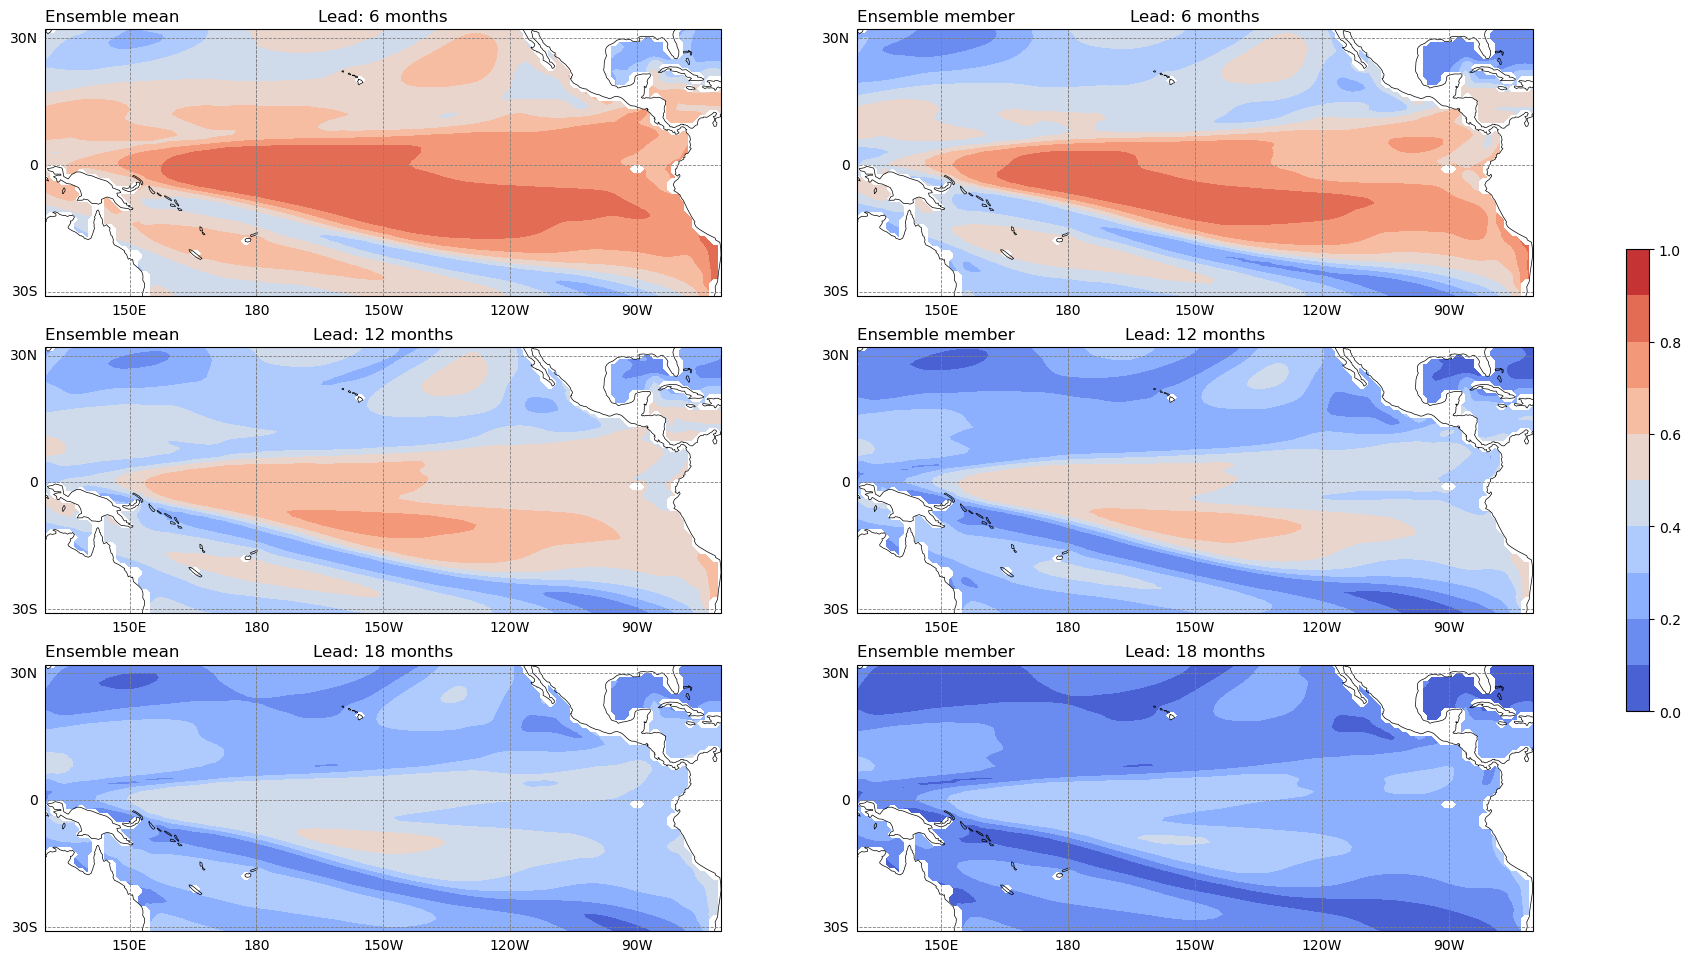

In [104]:
corr_memb=xr.open_dataarray('Forecasts 200/Skill metrics/corr_pattern_200_memb_ALLgauss.nc')
corr_mean=xr.open_dataarray('Forecasts 200/Skill metrics/corr_pattern_200_mean_ALLgauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

### 30 GAUSS

In [84]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [85]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [86]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/30EOFs_forecast_p{n}.npy')

tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
tot_for_union=tot_for_union[(0,2,4,6,8,10,12,14,16),:,:,:]

In [87]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [ ]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 200/Skill metrics/corr_pattern_200_memb_30gauss.nc')
#corr_mean.to_netcdf('Forecasts 200/Skill metrics/corr_pattern_200_mean_30gauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


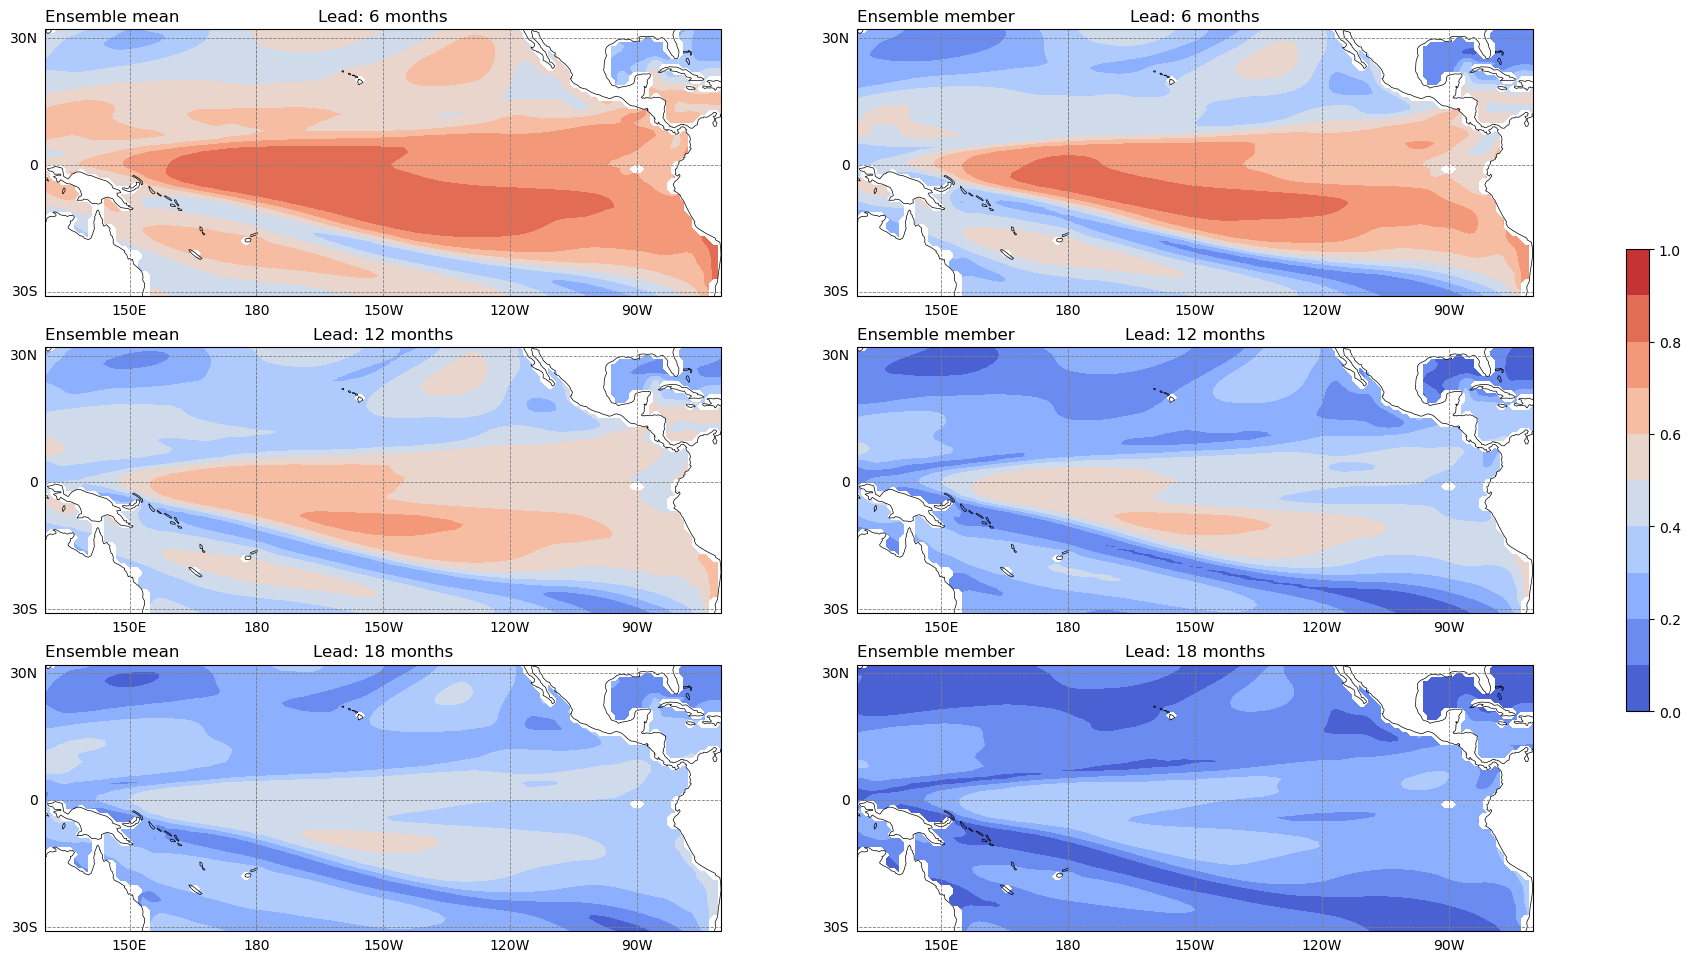

In [30]:
corr_memb=xr.open_dataarray('Forecasts 200/Skill metrics/corr_pattern_200_memb_30gauss.nc')
corr_mean=xr.open_dataarray('Forecasts 200/Skill metrics/corr_pattern_200_mean_30gauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

### POLY

In [84]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [85]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [86]:
### Load data

tot_for=np.zeros((20, 17, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/Poly_forecast_p{n}.npy')

tot_for_union=np.empty((17, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [ ]:
tot_for_union=tot_for_union[(0,2,4,6,8,10,12,14,16),:,:,:]

In [87]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [ ]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 200/Skill metrics/corr_pattern_200_memb_poly.nc')
#corr_mean.to_netcdf('Forecasts 200/Skill metrics/corr_pattern_200_mean_poly.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


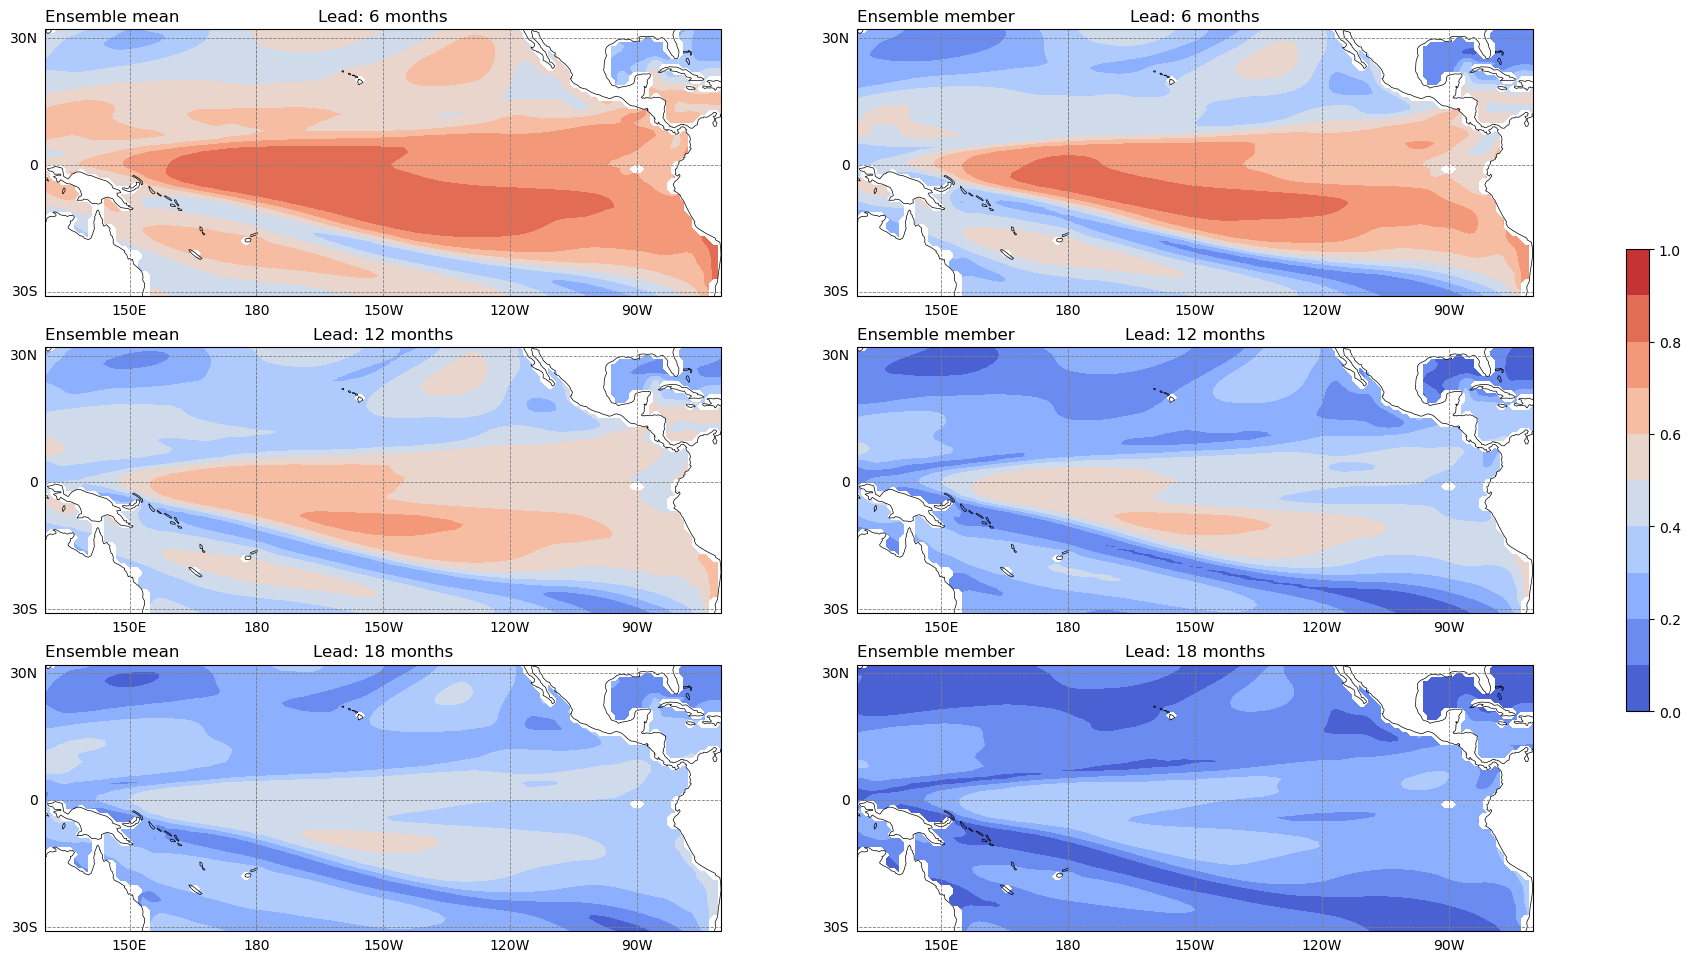

In [30]:
corr_memb=xr.open_dataarray('Forecasts 200/Skill metrics/corr_pattern_200_memb_poly.nc')
corr_mean=xr.open_dataarray('Forecasts 200/Skill metrics/corr_pattern_200_mean_poly.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

# 400 years

In [31]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
#operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
leads=[6,12,18]

## ALL GAUSS

In [32]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [33]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [34]:
### Load data

tot_for=np.zeros((20, 7, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [35]:
### Select just NON OVERLAPPING
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]

In [36]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [41]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 400/Skill metrics/corr_pattern_400_memb_ALLgauss.nc')
#corr_mean.to_netcdf('Forecasts 400/Skill metrics/corr_pattern_400_mean_ALLgauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


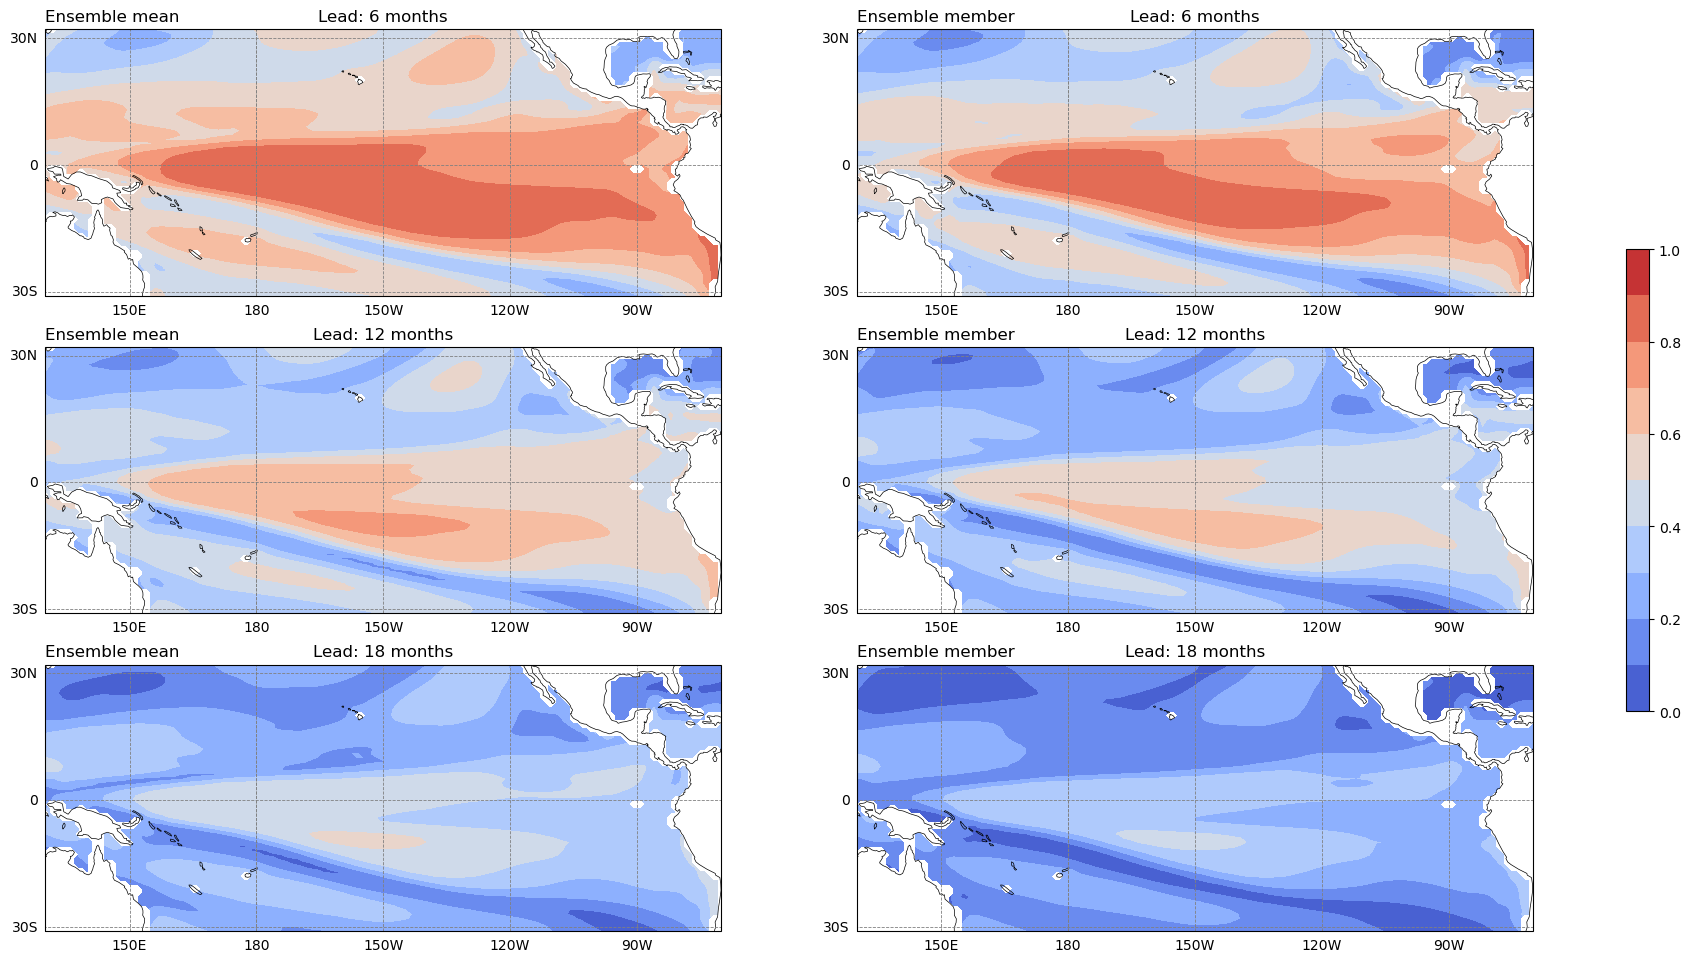

In [43]:
corr_memb=xr.open_dataarray('Forecasts 400/Skill metrics/corr_pattern_400_memb_ALLgauss.nc')
corr_mean=xr.open_dataarray('Forecasts 400/Skill metrics/corr_pattern_400_mean_ALLgauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

## 30 GAUSS

In [44]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [45]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [46]:
### Load data

tot_for=np.zeros((20, 7, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/30EOFs_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [47]:
### Select just NON OVERLAPPING
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]

In [48]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [49]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')


#corr_memb.to_netcdf('Forecasts 400/Skill metrics/corr_pattern_400_memb_30gauss.nc')
#corr_mean.to_netcdf('Forecasts 400/Skill metrics/corr_pattern_400_mean_30gauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


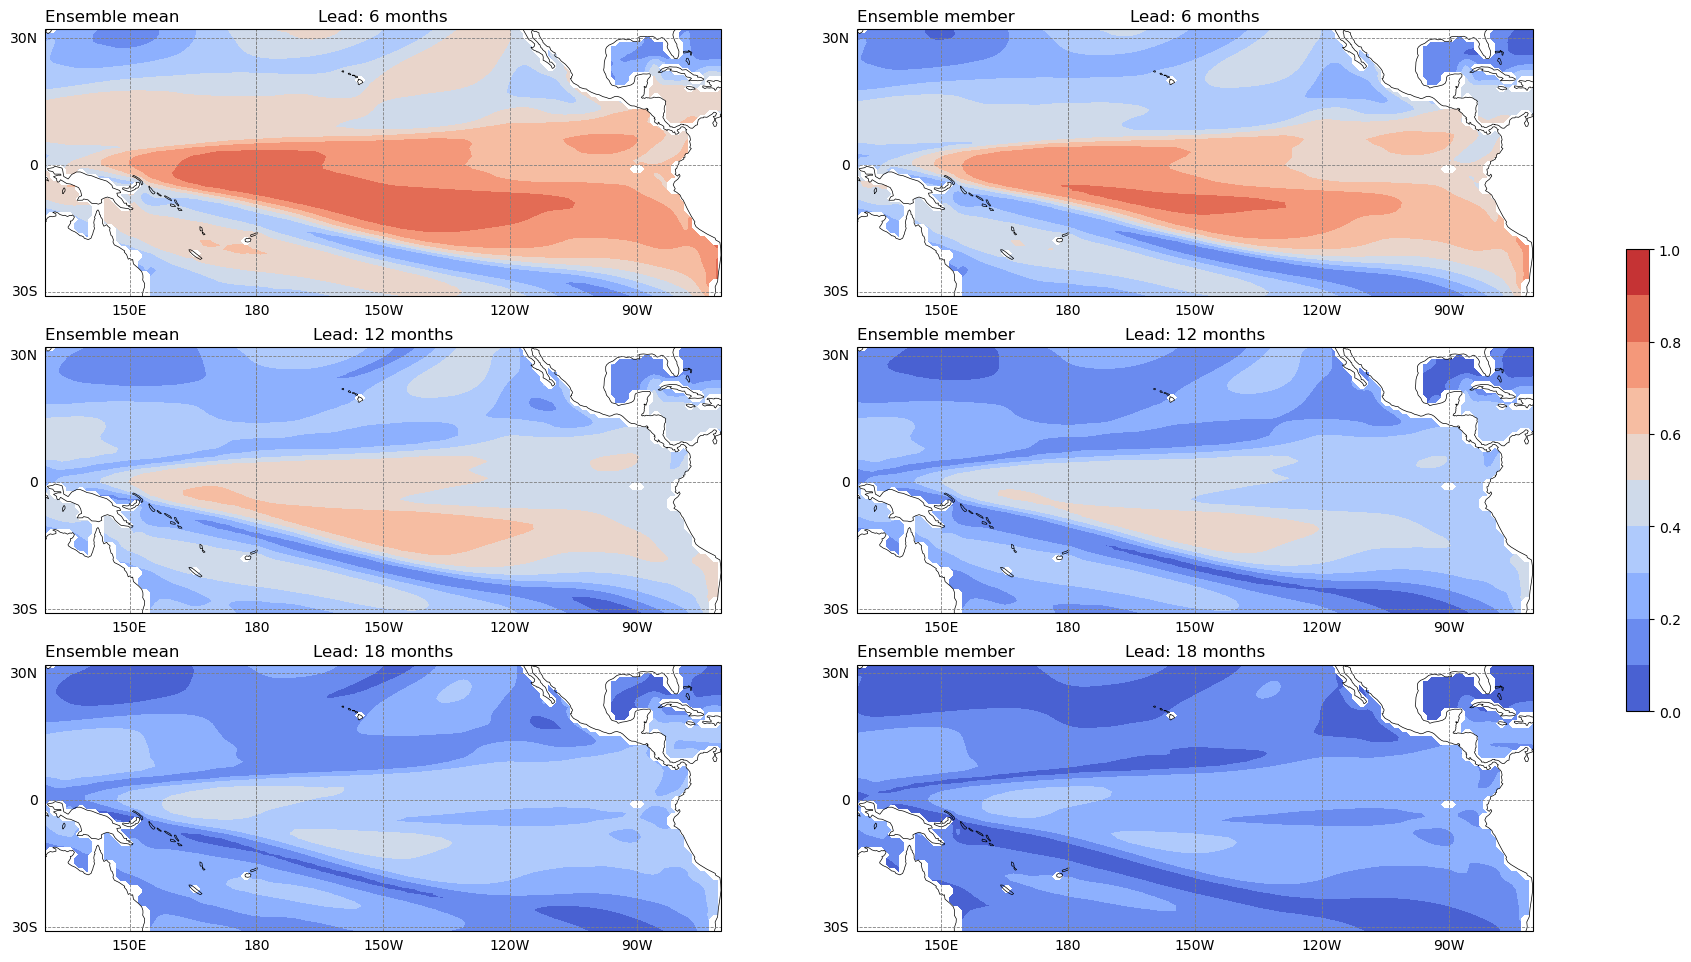

In [38]:
corr_memb=xr.open_dataarray('Forecasts 400/Skill metrics/corr_pattern_400_memb_30gauss.nc')
corr_mean=xr.open_dataarray('Forecasts 400/Skill metrics/corr_pattern_400_mean_30gauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

## 30 POLY

In [51]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [52]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [53]:
### Load data

tot_for=np.zeros((20, 7, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 400/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((7, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


del(tot_for)

In [54]:
### Select just NON OVERLAPPING
tot_for_union=tot_for_union[[0,2,4,6],:,:,:]

In [55]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [56]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(4):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')
#corr_memb.to_netcdf('Forecasts 400/Skill metrics/corr_pattern_400_memb_poly.nc')
#corr_mean.to_netcdf('Forecasts 400/Skill metrics/corr_pattern_400_mean_poly.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


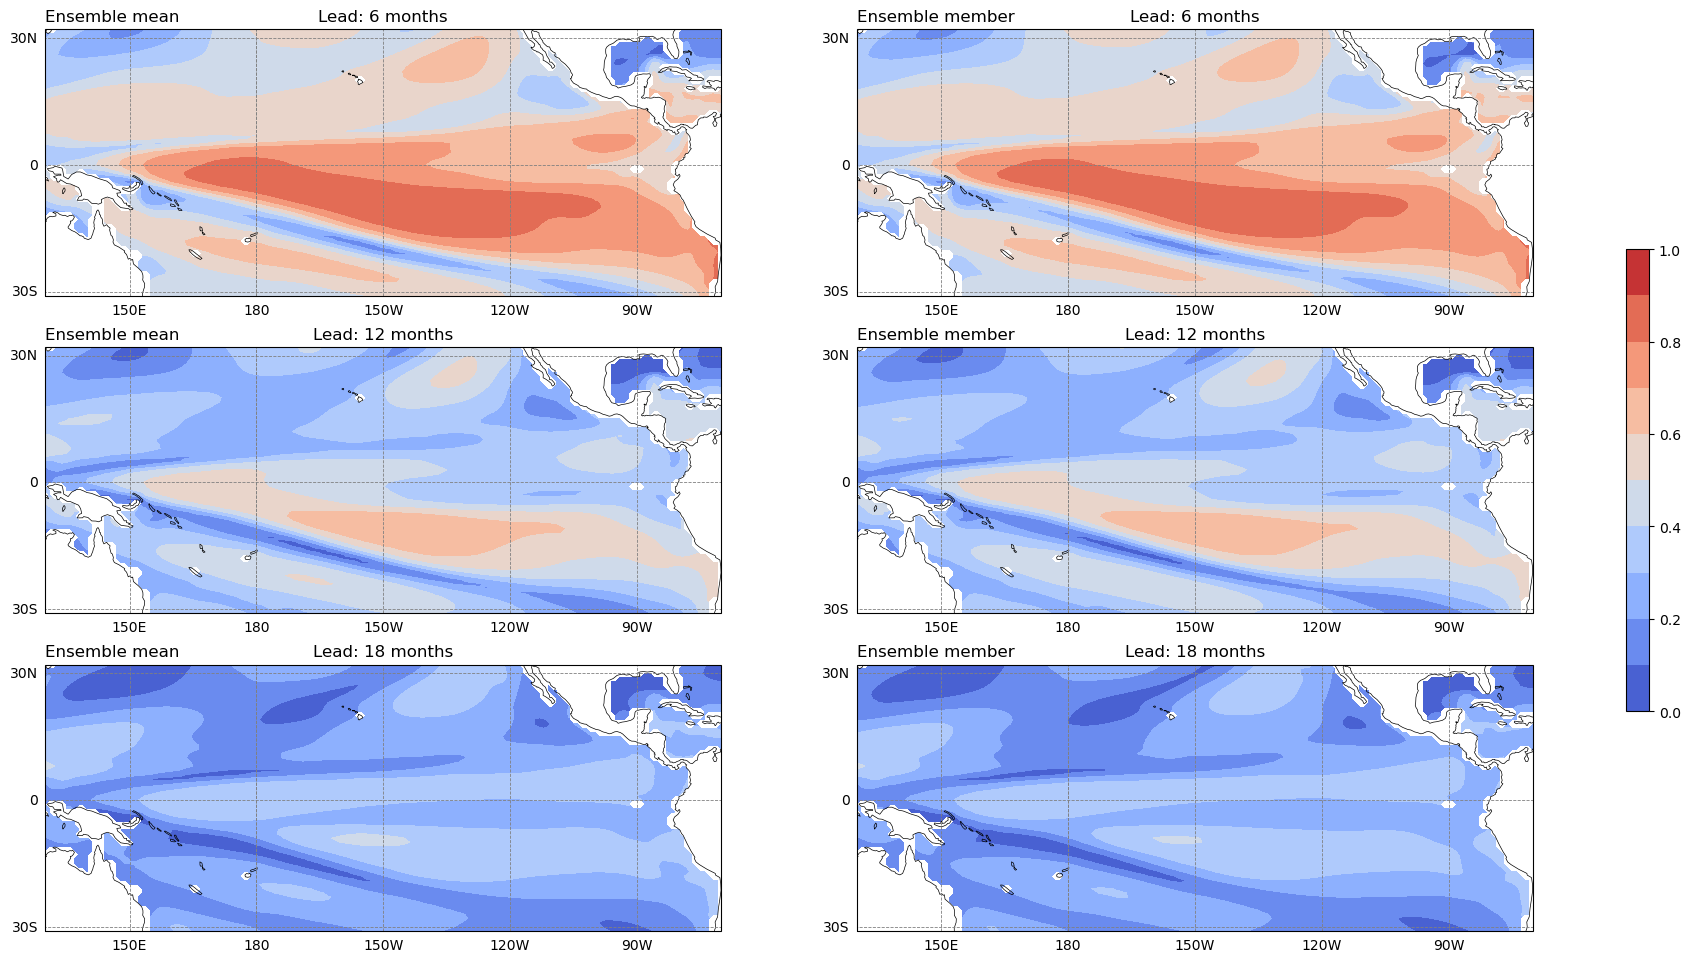

In [45]:
corr_memb=xr.open_dataarray('Forecasts 400/Skill metrics/corr_pattern_400_memb_poly.nc')
corr_mean=xr.open_dataarray('Forecasts 400/Skill metrics/corr_pattern_400_mean_poly.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

# 1000 years

In [58]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [59]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
#operators=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
leads=[6,12,18]

## ALL GAUSS

In [60]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [61]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [62]:
### Load data

tot_for=np.zeros((20, 1, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 1000/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((1, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [63]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [64]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(1):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')

#corr_memb.to_netcdf('Forecasts 1000/Skill metrics/corr_pattern_1000_memb_ALLgauss.nc')
#corr_mean.to_netcdf('Forecasts 1000/Skill metrics/corr_pattern_1000_mean_ALLgauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


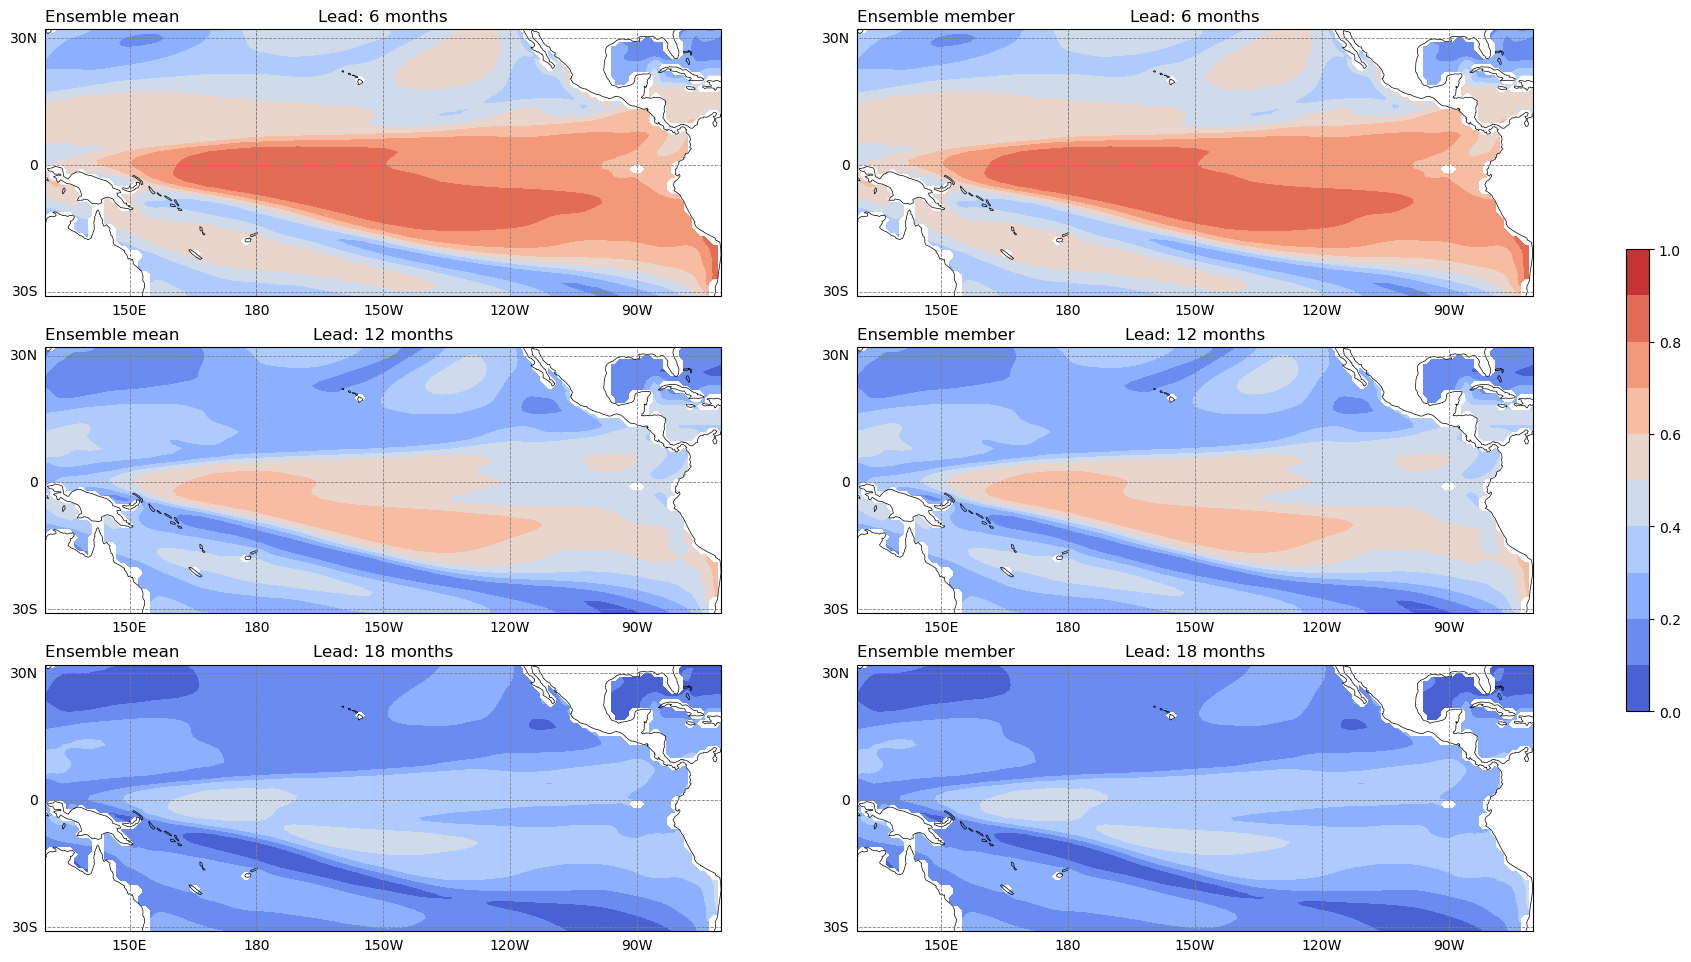

In [66]:
corr_memb=xr.open_dataarray('Forecasts 1000/Skill metrics/corr_pattern_1000_memb_ALLgauss.nc')
corr_mean=xr.open_dataarray('Forecasts 1000/Skill metrics/corr_pattern_1000_mean_ALLgauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

## 30 GAUSS

In [67]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [68]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [69]:
### Load data

tot_for=np.zeros((20, 1, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 1000/30EOFs_forecast_p{n}.npy')

tot_for_union=np.empty((1, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [70]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [71]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(1):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')


corr_memb.to_netcdf('Forecasts 1000/Skill metrics/corr_pattern_1000_memb_30gauss.nc')
corr_mean.to_netcdf('Forecasts 1000/Skill metrics/corr_pattern_1000_mean_30gauss.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


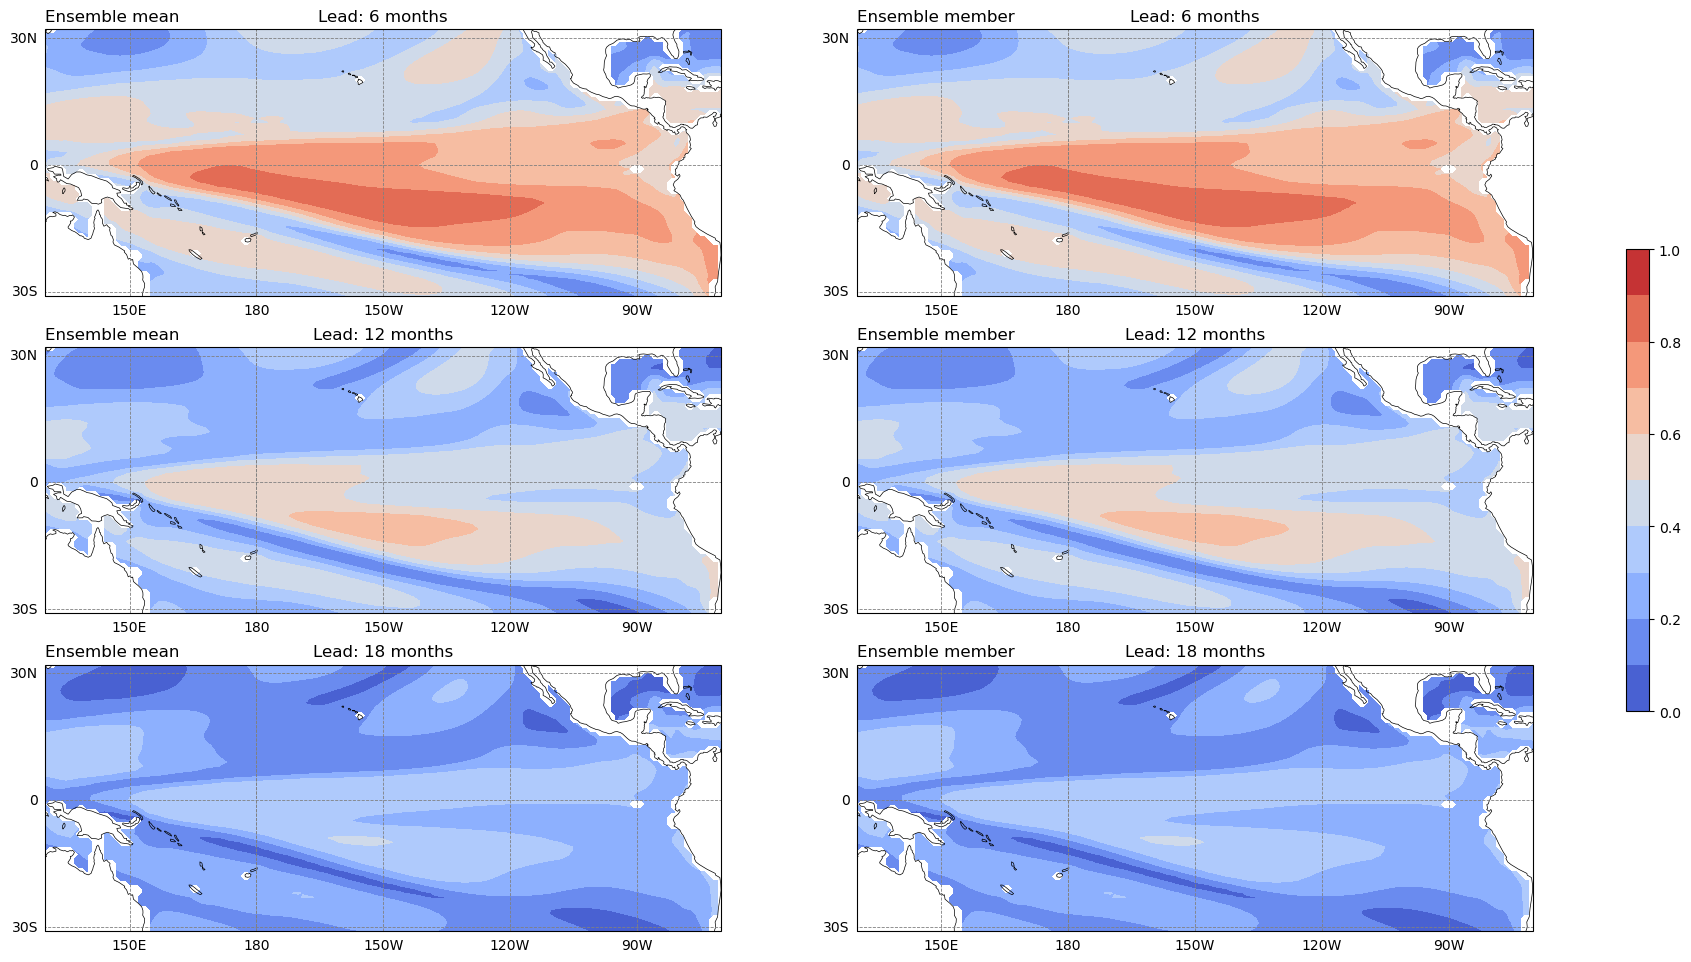

In [38]:
corr_memb=xr.open_dataarray('Forecasts 1000/Skill metrics/corr_pattern_1000_memb_30gauss.nc')
corr_mean=xr.open_dataarray('Forecasts 1000/Skill metrics/corr_pattern_1000_mean_30gauss.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

## 30 POLY

In [73]:
#Select EOFs
udat_sst=EOFs[:,0:20]

In [74]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [75]:
### Load data

tot_for=np.zeros((20, 1, 30, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 1000/POLY_forecast_p{n}.npy')

tot_for_union=np.empty((1, 30, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]


del(tot_for)

In [76]:
corr_mean=xr.full_like(Obs[0:3,:,:],0)
corr_memb=xr.full_like(Obs[0:3,:,:],0)

In [79]:
for n in range(3):

    lead=leads[n]

    ## Compute average forecast
    av_for=np.mean(tot_for_union, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos.A[:,:],0)
    av_for_geo.data=av_for_geo_array.real
     
    #Correlation average forecast and observations
    corr_mean[n]=xr.corr(Obs,av_for_geo.unstack(), dim='time')
    
    
    ## Compute member forecats
    corr_ind_geo = xr.full_like(Obs[0,:,:],0).expand_dims(dim={"forecasts": tot_for_union.shape[0]}).unstack().copy()
    
    for i in range(1):  
        phix_geo_array=udat_sst @ tot_for_union[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos.A[:,:],0)
        phix_geo.data=phix_geo_array.real
        corr_ind_geo[i,:,:]=xr.corr(Obs,phix_geo.unstack(), dim='time')
    
    #Mean correlation member forecasts and observations
    corr_memb[n]=corr_ind_geo.mean(dim='forecasts')
#corr_memb.to_netcdf('Forecasts 1000/Skill metrics/corr_pattern_1000_memb_poly.nc')
#corr_mean.to_netcdf('Forecasts 1000/Skill metrics/corr_pattern_1000_mean_poly.nc')

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1


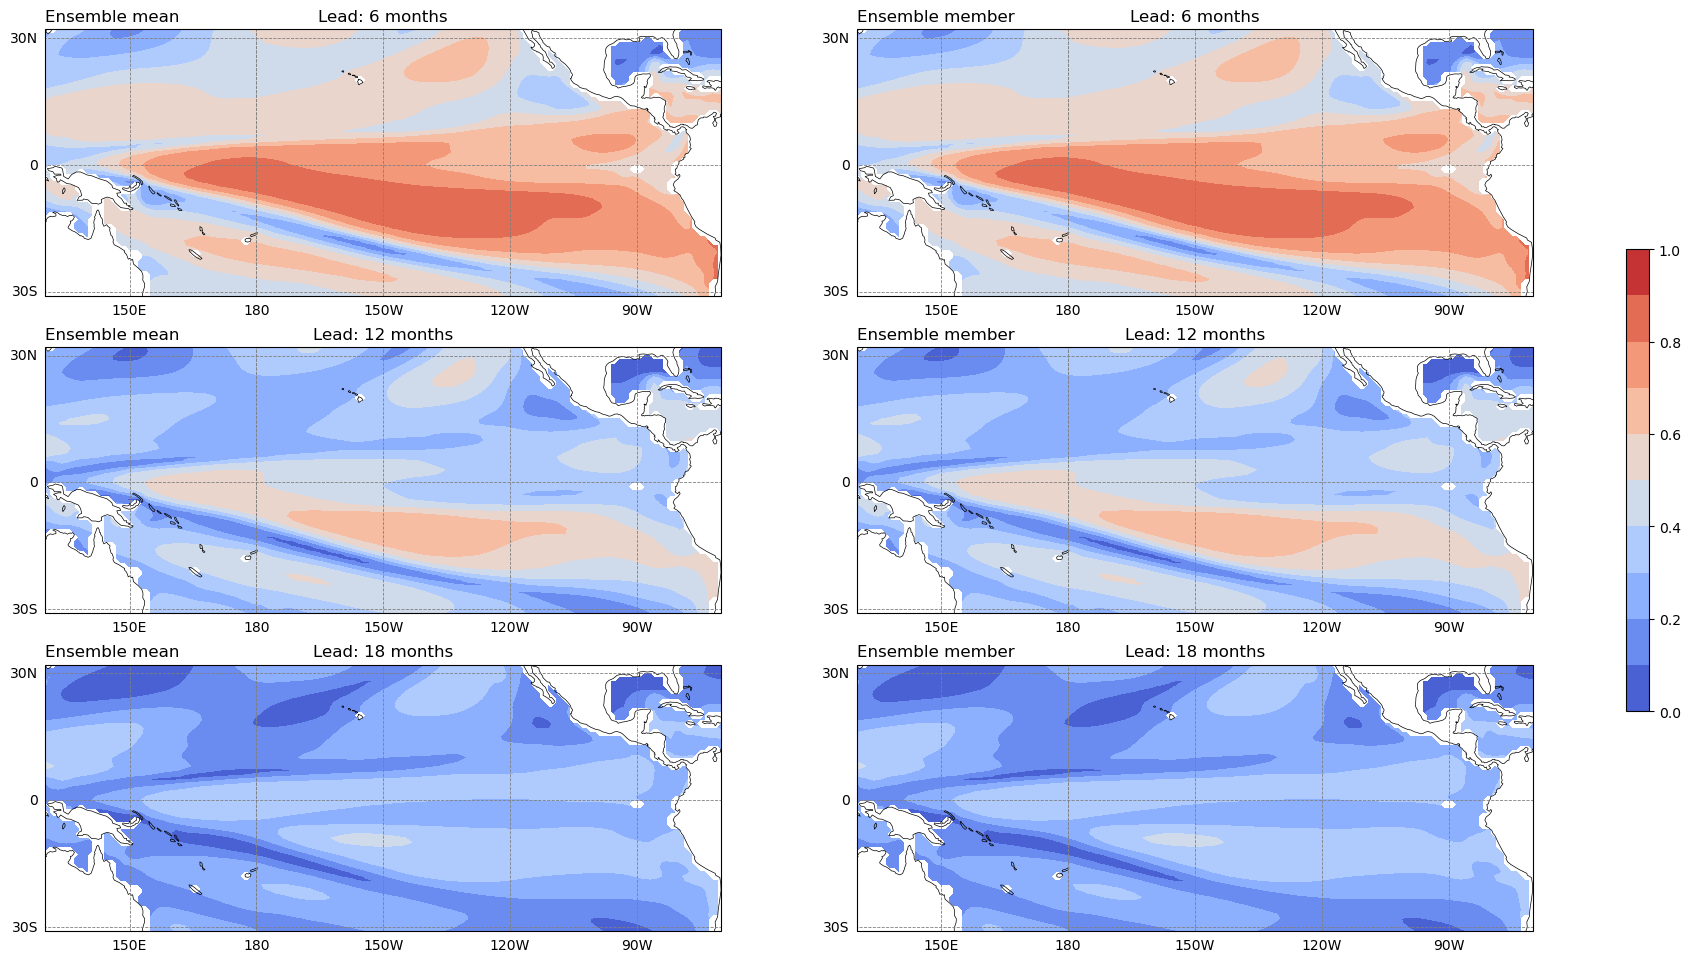

In [44]:
corr_memb=xr.open_dataarray('Forecasts 1000/Skill metrics/corr_pattern_1000_memb_poly.nc')
corr_mean=xr.open_dataarray('Forecasts 1000/Skill metrics/corr_pattern_1000_mean_poly.nc')

columns = 2
rows = 3
cont1=[0.1,0.9,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

handle=zmap.xmap(corr_mean[0,:,:],cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[1,:,:],cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_mean[2,:,:],cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble mean','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[0,:,:],cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 6 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[1,:,:],cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 12 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(corr_memb[2,:,:],cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'Lead: 18 months', 'lefttitle':'Ensemble member','righttitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.2,hspace=0.1)
plt.colorbar(handle['filled'], ax=ax,shrink=0.5)


plt.show()

# Old Fig 9

In [42]:
GALL_100_mean= xr.open_dataarray("Forecasts 100/Skill metrics/corr_pattern_100_mean_ALLgauss.nc")
GALL_100_memb= xr.open_dataarray("Forecasts 100/Skill metrics/corr_pattern_100_memb_ALLgauss.nc")

 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  0.1   to 0.9  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.25   to 0.25  with interval   0.05
Setting Fixed Contours
 Contouring from  -0.25   to 0.25  with interval   0.05
Setting Fixed Contours
 Contouring from  -0.25   to 0.25  with interval   0.05


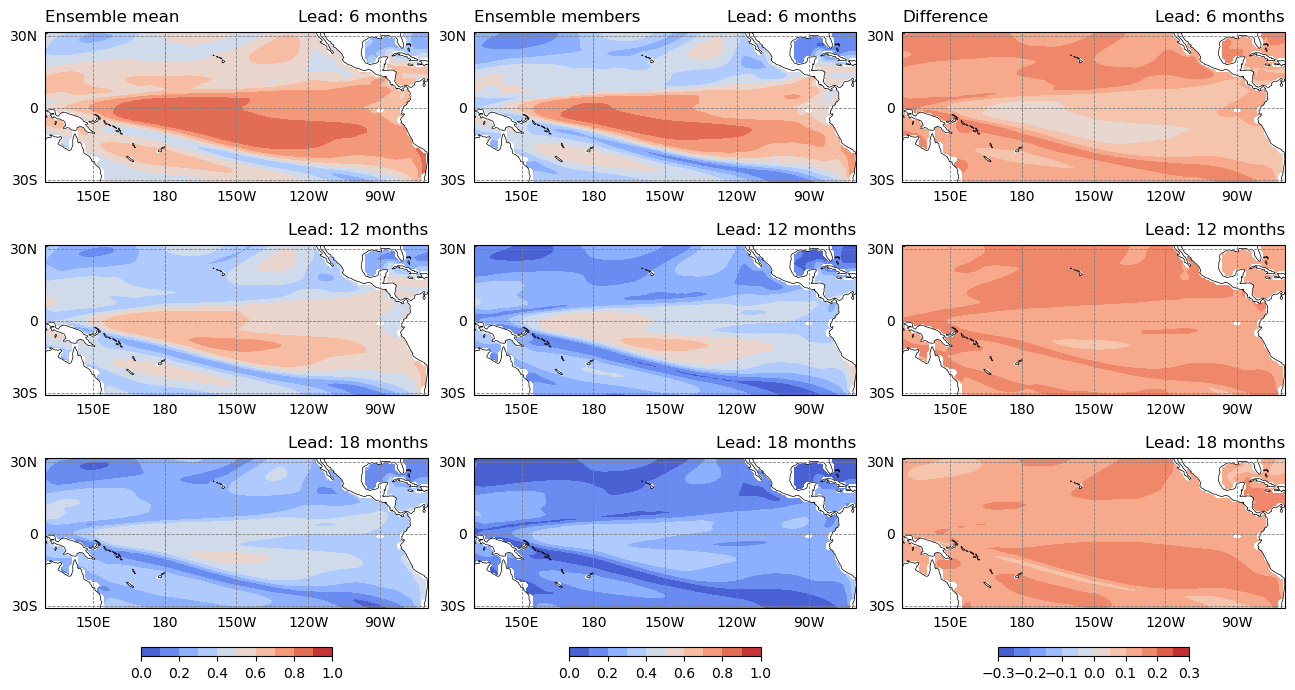

In [48]:
columns = 3
rows = 3
cont1=[0.1,0.9,0.1]
cont2=[-0.25,0.25,0.05]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,10), sharex=True, sharey=True )

# Ens mean
handle0=zmap.xmap(GALL_100_mean.unstack().isel(time=0),cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'Ensemble mean','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle0=zmap.xmap(GALL_100_mean.unstack().isel(time=1),cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle0=zmap.xmap(GALL_100_mean.unstack().isel(time=2),cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

# Ens members
handle1=zmap.xmap(GALL_100_memb.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'Ensemble members','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(GALL_100_memb.unstack().isel(time=1),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle1=zmap.xmap(GALL_100_memb.unstack().isel(time=2),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


# POLY
handle2=zmap.xmap(GALL_100_mean.unstack().isel(time=0)-GALL_100_memb.unstack().isel(time=0),cont2, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 6 months', 'lefttitle':'Difference','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle2=zmap.xmap(GALL_100_mean.unstack().isel(time=1)-GALL_100_memb.unstack().isel(time=1),cont2, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 12 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle2=zmap.xmap(GALL_100_mean.unstack().isel(time=2)-GALL_100_memb.unstack().isel(time=2),cont2, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'righttitle':'Lead: 18 months', 'lefttitle':'','maintitle':''},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


ax[0,0].xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(ax[0,0],fontsize=18,fontfamily='Futura',fontweight='bold')
zmap.changebox(ax[0,0],'all',linewidth=1.5)  

plt.subplots_adjust(wspace=0.12,hspace=0.12)

plt.colorbar(handle0['filled'], ax=list(ax[0:3,1]),shrink=0.5, orientation = 'horizontal',pad=0.05)
plt.colorbar(handle0['filled'], ax=list(ax[0:3,0]),shrink=0.5, orientation = 'horizontal',pad=0.05)
plt.colorbar(handle2['filled'], ax=list(ax[0:3,2]),shrink=0.5, orientation = 'horizontal',pad=0.05)

plt.savefig('Fig 9.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 9.jpg', orientation='landscape',  format='jpg')

plt.show()

# Old Fig 10

In [49]:
GALL_1000= xr.open_dataarray("Forecasts 1000/Skill metrics/corr_pattern_1000_mean_ALLgauss.nc")
POLY_1000= xr.open_dataarray("Forecasts 1000/Skill metrics/corr_pattern_1000_mean_poly.nc")

GALL_400= xr.open_dataarray("Forecasts 400/Skill metrics/corr_pattern_400_mean_ALLgauss.nc")
POLY_400= xr.open_dataarray("Forecasts 400/Skill metrics/corr_pattern_400_mean_poly.nc")

GALL_200= xr.open_dataarray("Forecasts 200/Skill metrics/corr_pattern_200_mean_ALLgauss.nc")
POLY_200= xr.open_dataarray("Forecasts 200/Skill metrics/corr_pattern_200_mean_poly.nc")

GALL_100= xr.open_dataarray("Forecasts 100/Skill metrics/corr_pattern_100_mean_ALLgauss.nc")
POLY_100= xr.open_dataarray("Forecasts 100/Skill metrics/corr_pattern_100_mean_poly.nc")

GALL_50= xr.open_dataarray("Forecasts 50/Skill metrics/corr_pattern_50_mean_ALLgauss.nc")
POLY_50= xr.open_dataarray("Forecasts 50/Skill metrics/corr_pattern_50_mean_poly.nc")


 Opening figure , 3 rows and 5 cols 

Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to

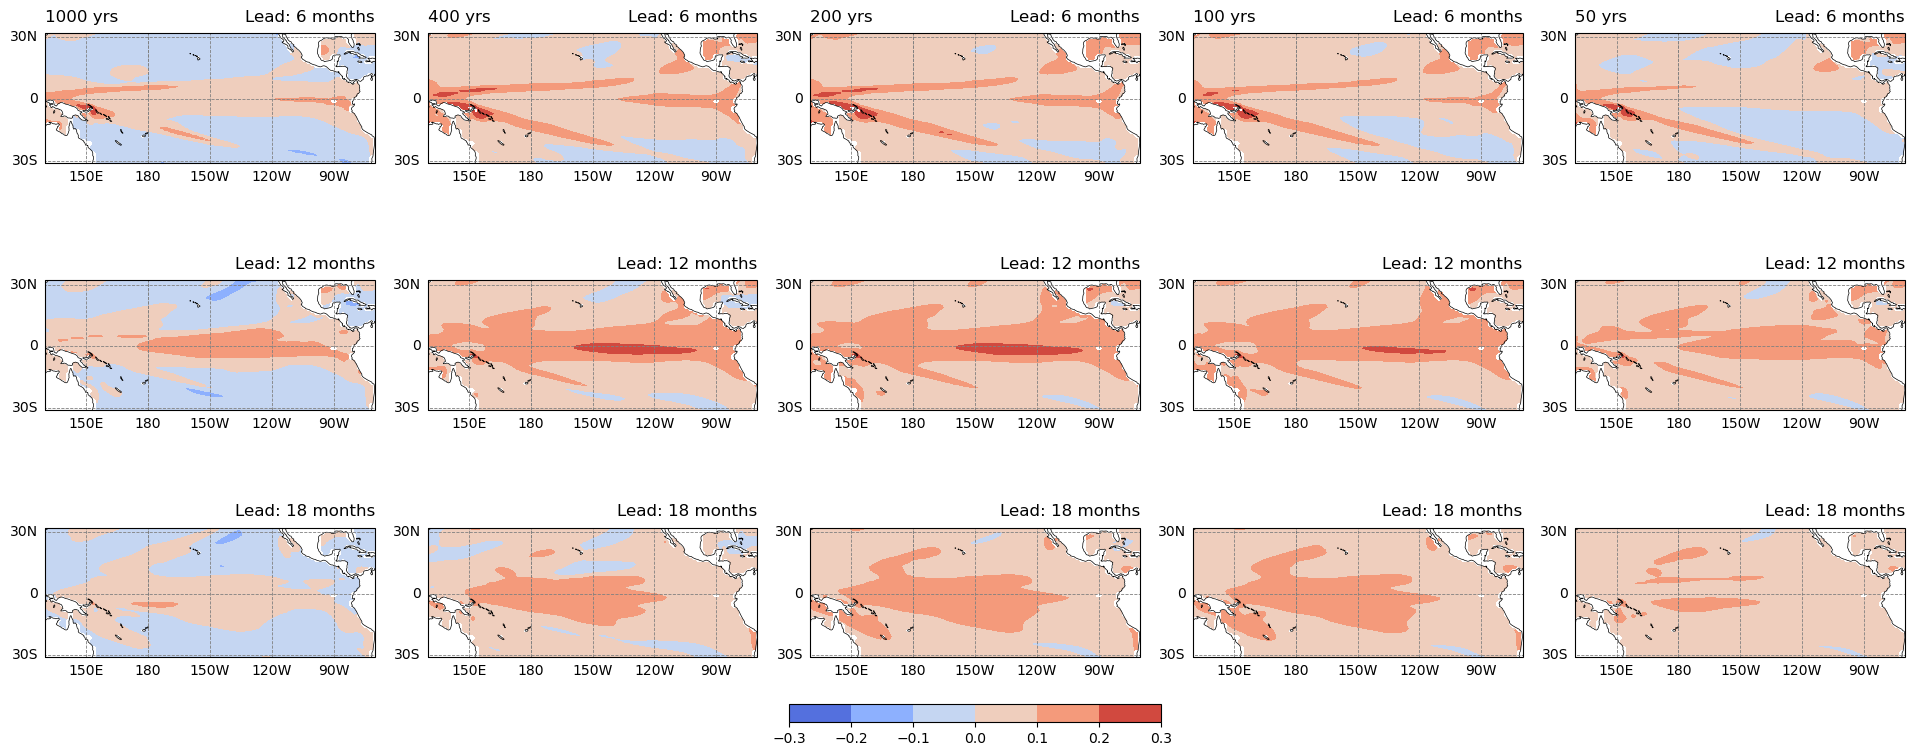

In [36]:
# EXTENDED

columns = 5
rows = 3
cont1=[-0.2,0.2,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(24,12), sharex=True, sharey=True )
axh=ax[0,0]

#1000
handle=zmap.xmap(GALL_1000.unstack().isel(time=0)-POLY_1000.unstack().isel(time=0),cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'1000 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_1000.unstack().isel(time=1)-POLY_1000.unstack().isel(time=1),cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_1000.unstack().isel(time=2)-POLY_1000.unstack().isel(time=2),cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

#400
handle=zmap.xmap(GALL_400.unstack().isel(time=0)-POLY_400.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'400 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=1)-POLY_400.unstack().isel(time=1),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=2)-POLY_400.unstack().isel(time=2),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


#200
handle=zmap.xmap(GALL_200.unstack().isel(time=0)-POLY_200.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'200 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=1)-POLY_200.unstack().isel(time=1),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=2)-POLY_200.unstack().isel(time=2),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

#100
handle=zmap.xmap(GALL_100.unstack().isel(time=0)-POLY_100.unstack().isel(time=0),cont1, pro, ax=ax[0,3],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'100 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_100.unstack().isel(time=1)-POLY_100.unstack().isel(time=1),cont1, pro, ax=ax[1,3],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_100.unstack().isel(time=2)-POLY_100.unstack().isel(time=2),cont1, pro, ax=ax[2,3],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


#50
handle=zmap.xmap(GALL_50.unstack().isel(time=0)-POLY_50.unstack().isel(time=0),cont1, pro, ax=ax[0,4],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'50 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_50.unstack().isel(time=1)-POLY_50.unstack().isel(time=1),cont1, pro, ax=ax[1,4],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_50.unstack().isel(time=2)-POLY_50.unstack().isel(time=2),cont1, pro, ax=ax[2,4],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.15,hspace=0.01)
plt.colorbar(handle['filled'], ax=ax, shrink=0.2, orientation = 'horizontal',pad=0.05)   

#plt.savefig('Fig 10.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 10.jpg', orientation='landscape',  format='jpg')

plt.show()

 Opening figure , 3 rows and 3 cols 

Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1


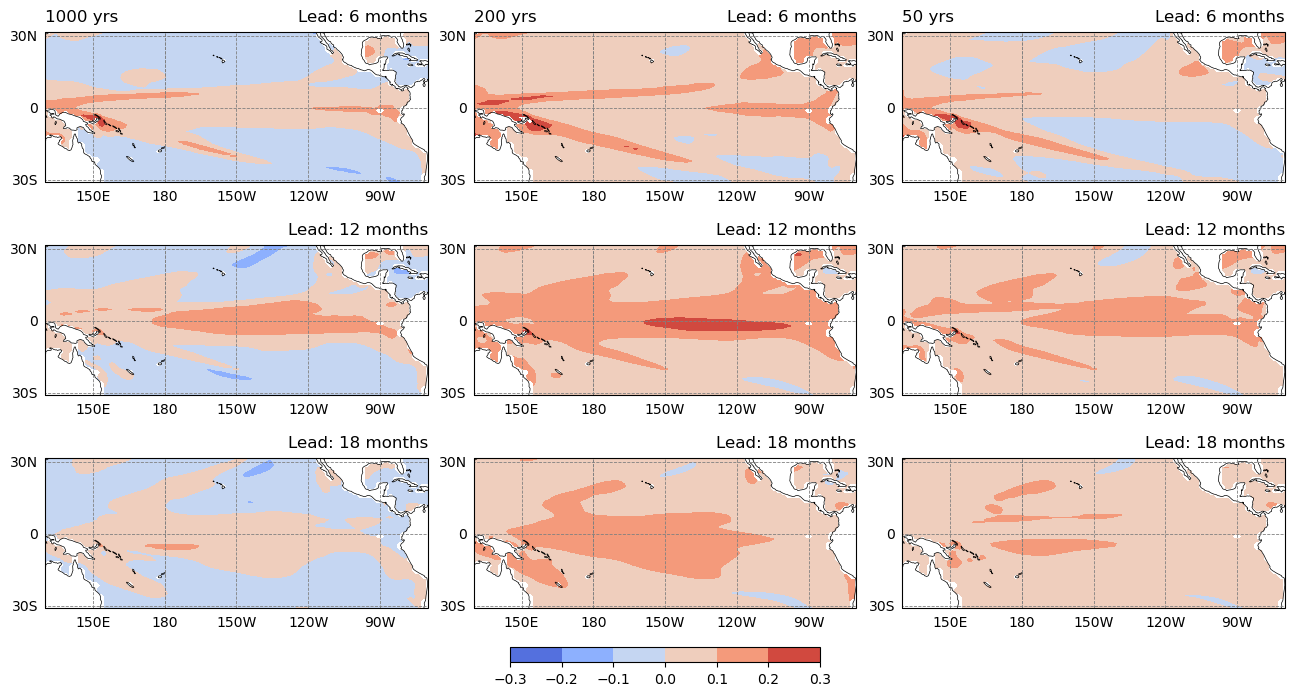

In [50]:
columns = 3
rows = 3
cont1=[-0.2,0.2,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(16,10), sharex=True, sharey=True )
axh=ax[0,0]

#1000
handle=zmap.xmap(GALL_1000.unstack().isel(time=0)-POLY_1000.unstack().isel(time=0),cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'1000 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_1000.unstack().isel(time=1)-POLY_1000.unstack().isel(time=1),cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_1000.unstack().isel(time=2)-POLY_1000.unstack().isel(time=2),cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

#200
handle=zmap.xmap(GALL_200.unstack().isel(time=0)-POLY_200.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'200 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=1)-POLY_200.unstack().isel(time=1),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=2)-POLY_200.unstack().isel(time=2),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


#50
handle=zmap.xmap(GALL_50.unstack().isel(time=0)-POLY_50.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'50 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_50.unstack().isel(time=1)-POLY_50.unstack().isel(time=1),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_50.unstack().isel(time=2)-POLY_50.unstack().isel(time=2),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.12,hspace=0.12)
plt.colorbar(handle['filled'], ax=ax,shrink=0.25, orientation = 'horizontal',pad=0.05)    #, orientation = 'horizontal'

plt.savefig('Fig 10.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 10.jpg', orientation='landscape',  format='jpg')

plt.show()

# Old Fig 11

In [25]:
GALL_1000= xr.open_dataarray("Forecasts 1000/Skill metrics/corr_pattern_1000_mean_ALLgauss.nc")
GALL_400= xr.open_dataarray("Forecasts 400/Skill metrics/corr_pattern_400_mean_ALLgauss.nc")
GALL_200= xr.open_dataarray("Forecasts 200/Skill metrics/corr_pattern_200_mean_ALLgauss.nc")
GALL_100= xr.open_dataarray("Forecasts 100/Skill metrics/corr_pattern_100_mean_ALLgauss.nc")
GALL_50= xr.open_dataarray("Forecasts 50/Skill metrics/corr_pattern_50_mean_ALLgauss.nc")

 Opening figure , 3 rows and 4 cols 

Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025
Setting Fixed Contours
 Contouring from  -0.1   to 0.1  with interval   0.025


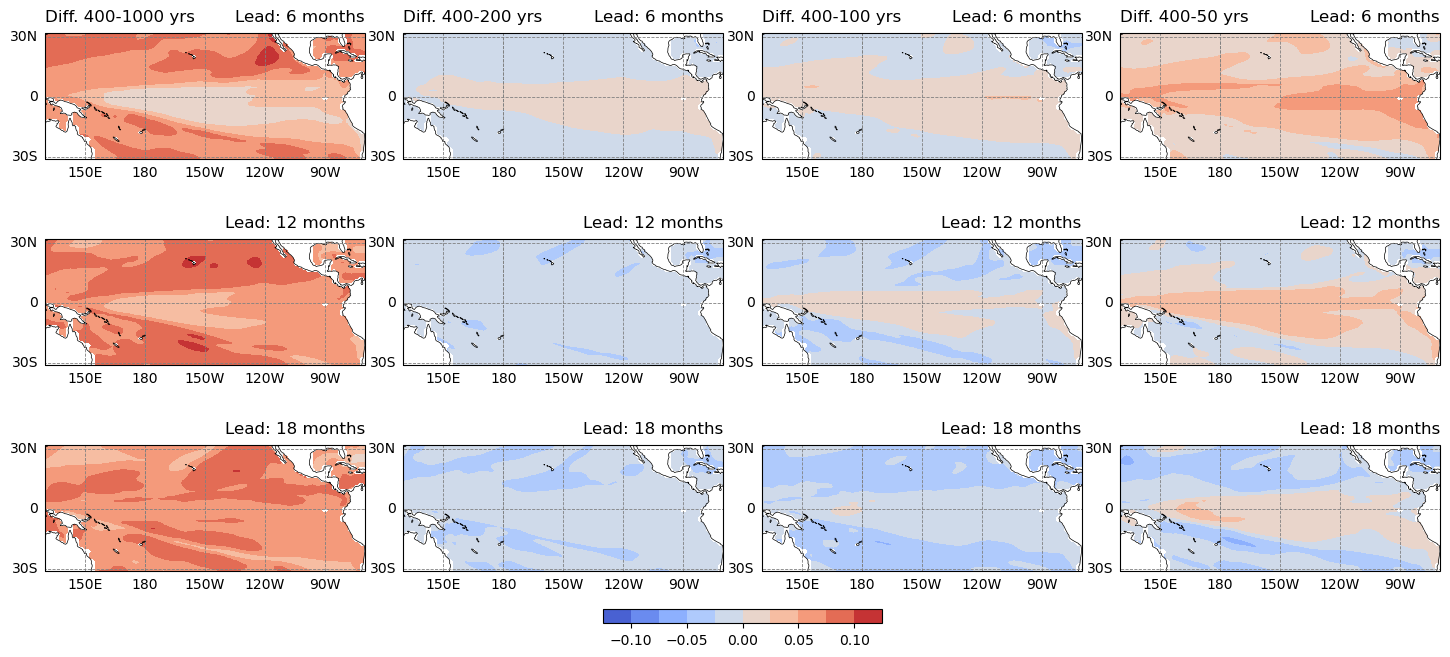

In [51]:
columns = 4
rows = 3
cont1=[-0.1,0.1,0.025]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(18,10), sharex=True, sharey=True )
axh=ax[0,0]

#400-1000
handle=zmap.xmap(GALL_400.unstack().isel(time=0)-GALL_1000.unstack().isel(time=0),cont1, pro, ax=ax[0,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'Diff. 400-1000 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=1)-GALL_1000.unstack().isel(time=1),cont1, pro, ax=ax[1,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=2)-GALL_1000.unstack().isel(time=2),cont1, pro, ax=ax[2,0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

#400-400
handle=zmap.xmap(GALL_400.unstack().isel(time=0)-GALL_200.unstack().isel(time=0),cont1, pro, ax=ax[0,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'Diff. 400-200 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=1)-GALL_200.unstack().isel(time=1),cont1, pro, ax=ax[1,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=2)-GALL_200.unstack().isel(time=2),cont1, pro, ax=ax[2,1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


#400-100
handle=zmap.xmap(GALL_400.unstack().isel(time=0)-GALL_100.unstack().isel(time=0),cont1, pro, ax=ax[0,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'Diff. 400-100 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=1)-GALL_100.unstack().isel(time=1),cont1, pro, ax=ax[1,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=2)-GALL_100.unstack().isel(time=2),cont1, pro, ax=ax[2,2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

#400-50
handle=zmap.xmap(GALL_400.unstack().isel(time=0)-GALL_50.unstack().isel(time=0),cont1, pro, ax=ax[0,3],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'Diff. 400-50 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=1)-GALL_50.unstack().isel(time=1),cont1, pro, ax=ax[1,3],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_400.unstack().isel(time=2)-GALL_50.unstack().isel(time=2),cont1, pro, ax=ax[2,3],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.12,hspace=0.01)
plt.colorbar(handle['filled'], ax=ax, shrink=0.2, orientation = 'horizontal',pad=0.05)   

plt.savefig('Fig 11.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 11.jpg', orientation='landscape',  format='jpg')

plt.show()

# Fig 6

In [20]:
GALL_200= xr.open_dataarray("Forecasts 200/Skill metrics/corr_pattern_200_mean_ALLgauss.nc")
POLY_200= xr.open_dataarray("Forecasts 200/Skill metrics/corr_pattern_200_mean_poly.nc")

 Opening figure , 3 rows and 1 cols 

Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1


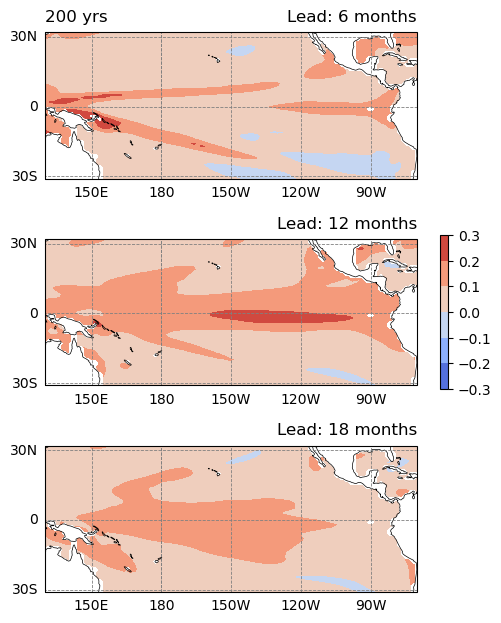

In [21]:
columns = 1
rows = 3
cont1=[-0.2,0.2,0.1]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(6,8), sharex=True, sharey=True )
axh=ax[0]

#200
handle=zmap.xmap(GALL_200.unstack().isel(time=0)-POLY_200.unstack().isel(time=0),cont1, pro, ax=ax[0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'200 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=1)-POLY_200.unstack().isel(time=1),cont1, pro, ax=ax[1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=2)-POLY_200.unstack().isel(time=2),cont1, pro, ax=ax[2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.colorbar(handle['filled'], ax=ax,shrink=0.25, orientation = 'vertical',pad=0.05)    #, orientation = 'horizontal'

#plt.savefig('Fig 7.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 7.jpg', orientation='landscape',  format='jpg')

plt.show()

In [82]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load data
linear_corr = POLY_200
gaussian_corr = GALL_200

# Compute the difference between the two correlation maps
diff_corr = linear_corr - gaussian_corr

# Function to compute confidence interval for each correlation map
def compute_conf_interval(corr_map, n, confidence=0.95):
    z_map = np.arctanh(corr_map)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_crit = norm.ppf(1 - (1 - confidence) / 2)  # Critical value for desired confidence level
    z_lower = z_map - z_crit * se
    z_upper = z_map + z_crit * se
    lower = np.tanh(z_lower)  # Inverse Fisher transformation
    upper = np.tanh(z_upper)
    return lower, upper

# Example sample size
n = 21600

# Compute confidence intervals for both correlation maps
linear_lower, linear_upper = compute_conf_interval(linear_corr, n)
gaussian_lower, gaussian_upper = compute_conf_interval(gaussian_corr, n)

# Determine where the difference is significant
significant_mask_95 = (linear_upper < gaussian_lower) | (linear_lower > gaussian_upper)
significant_gaussian_95 = (gaussian_lower > 0) | (gaussian_upper < 0)

In [105]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load data
linear_corr = POLY_200
gaussian_corr = GALL_200

# Compute the difference between the two correlation maps
diff_corr = linear_corr - gaussian_corr

# Function to compute confidence interval for each correlation map
def compute_conf_interval(corr_map, n, confidence=0.99999):
    z_map = np.arctanh(corr_map)  # Fisher transformation
    se = 1 / np.sqrt(n - 3)  # Standard error
    z_crit = norm.ppf(1 - (1 - confidence) / 2)  # Critical value for desired confidence level
    z_lower = z_map - z_crit * se
    z_upper = z_map + z_crit * se
    lower = np.tanh(z_lower)  # Inverse Fisher transformation
    upper = np.tanh(z_upper)
    return lower, upper

# Example sample size
n = 21600

# Compute confidence intervals for both correlation maps
linear_lower, linear_upper = compute_conf_interval(linear_corr, n)
gaussian_lower, gaussian_upper = compute_conf_interval(gaussian_corr, n)

# Determine where the difference is significant
significant_mask_99 = (linear_upper < gaussian_lower) | (linear_lower > gaussian_upper)
significant_gaussian_99 = (gaussian_lower > 0) | (gaussian_upper < 0)

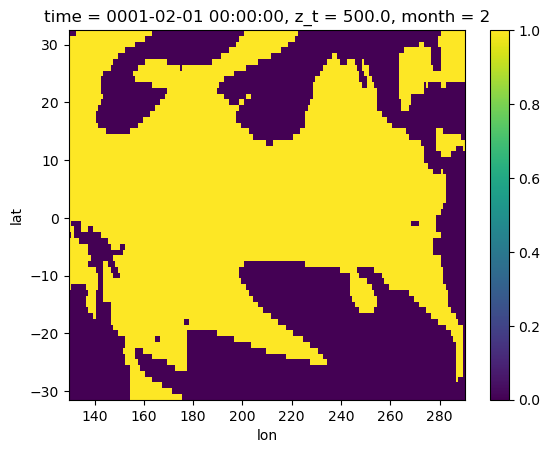

In [98]:
significant_mask_99.isel(time=0).plot()

In [84]:
lat=significant_mask_99.lat
lon=significant_mask_99.lon

 Opening figure , 3 rows and 1 cols 

Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1


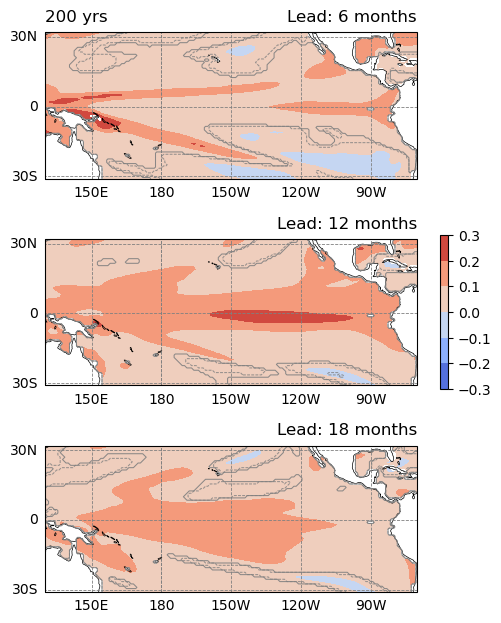

In [28]:
columns = 1
rows = 3
cont1=[-0.2,0.2,0.1]
cont2=[]

fig,ax,pro=zmap.init_figure(rows,columns,'Pacific', constrained_layout=False, figsize=(6,8), sharex=True, sharey=True )
axh=ax[0]

#200
handle=zmap.xmap(GALL_200.unstack().isel(time=0)-POLY_200.unstack().isel(time=0),cont1, pro, ax=ax[0],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'200 yrs','righttitle':'Lead: 6 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=1)-POLY_200.unstack().isel(time=1),cont1, pro, ax=ax[1],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 12 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))
handle=zmap.xmap(GALL_200.unstack().isel(time=2)-POLY_200.unstack().isel(time=2),cont1, pro, ax=ax[2],refline=None, c_format='{:4.2f}',data_cent_lon=0,\
                   title={'maintitle':'', 'lefttitle':'','righttitle':'Lead: 18 months'},cmap='coolwarm',contour=False, xlimit=(-50,110), ylimit=(-31,32))

# Overlay significant contours
ax[0].contour(lon-180, lat, significant_mask_95.isel(time=0), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.8, linestyles='dashed')
ax[1].contour(lon-180, lat, significant_mask_95.isel(time=1), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.8, linestyles='dashed')
ax[2].contour(lon-180, lat, significant_mask_95.isel(time=2), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.8, linestyles='dashed')

# Overlay significant contours
ax[0].contour(lon-180, lat, significant_mask_99.isel(time=0), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.9)
ax[1].contour(lon-180, lat, significant_mask_99.isel(time=1), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.9)
ax[2].contour(lon-180, lat, significant_mask_99.isel(time=2), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.9)


axh.xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh,fontsize=14,fontfamily='Futura',fontweight='bold')
zmap.changebox(axh,'all',linewidth=1.5)  
        
plt.subplots_adjust(wspace=0.02,hspace=0.02)
plt.colorbar(handle['filled'], ax=ax,shrink=0.25, orientation = 'vertical',pad=0.05)    #, orientation = 'horizontal'

plt.savefig('Fig 6.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 6.jpg', orientation='landscape',  format='jpg')

plt.show()

In [85]:
cmap0='coolwarm'
cont0 = [-0.9, 0.9, 0.15]

 Opening figure , 3 rows and 2 cols 

Setting Fixed Contours
 Contouring from  -0.9   to 0.9  with interval   0.15
Setting Fixed Contours
 Contouring from  -0.9   to 0.9  with interval   0.15
Setting Fixed Contours
 Contouring from  -0.9   to 0.9  with interval   0.15
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1
Setting Fixed Contours
 Contouring from  -0.2   to 0.2  with interval   0.1


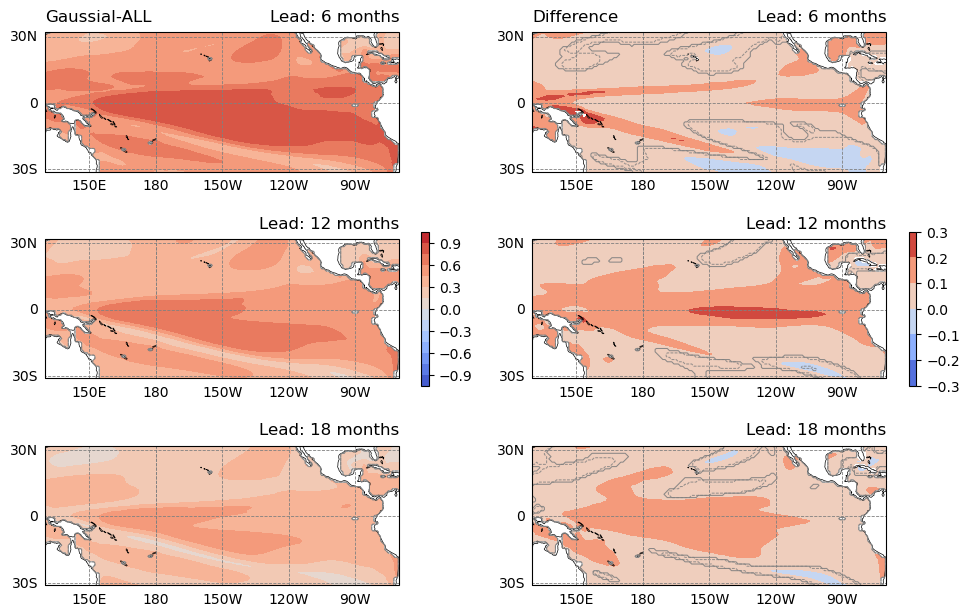

In [86]:
columns = 2  # Two columns, same plots in each
rows = 3
cont1 = [-0.2, 0.2, 0.1]

fig, ax, pro = zmap.init_figure(rows, columns, 'Pacific', constrained_layout=False, figsize=(12, 8), sharex=True, sharey=True)

# First column (200 yrs dataset)
handle1 = zmap.xmap(GALL_200.unstack().isel(time=0), cont0, pro, ax=ax[0, 0], refline=None, 
                   c_format='{:4.2f}', data_cent_lon=0, title={'maintitle': '', 'lefttitle': 'Gaussial-ALL', 'righttitle': 'Lead: 6 months'}, 
                   cmap=cmap0, contour=False, xlimit=(-50, 110), ylimit=(-31, 32))
handle1 = zmap.xmap(GALL_200.unstack().isel(time=1), cont0, pro, ax=ax[1, 0], refline=None, 
                   c_format='{:4.2f}', data_cent_lon=0, title={'maintitle': '', 'lefttitle': '', 'righttitle': 'Lead: 12 months'}, 
                   cmap=cmap0, contour=False, xlimit=(-50, 110), ylimit=(-31, 32))
handle1 = zmap.xmap(GALL_200.unstack().isel(time=2), cont0, pro, ax=ax[2, 0], refline=None, 
                   c_format='{:4.2f}', data_cent_lon=0, title={'maintitle': '', 'lefttitle': '', 'righttitle': 'Lead: 18 months'}, 
                   cmap=cmap0, contour=False, xlimit=(-50, 110), ylimit=(-31, 32))

# Second column (30 yrs dataset)
handle2 = zmap.xmap(GALL_200.unstack().isel(time=0) - POLY_200.unstack().isel(time=0), cont1, pro, ax=ax[0, 1], refline=None, 
                   c_format='{:4.2f}', data_cent_lon=0, title={'maintitle': '', 'lefttitle': 'Difference', 'righttitle': 'Lead: 6 months'}, 
                   cmap='coolwarm', contour=False, xlimit=(-50, 110), ylimit=(-31, 32))
handle2 = zmap.xmap(GALL_200.unstack().isel(time=1) - POLY_200.unstack().isel(time=1), cont1, pro, ax=ax[1, 1], refline=None, 
                   c_format='{:4.2f}', data_cent_lon=0, title={'maintitle': '', 'lefttitle': '', 'righttitle': 'Lead: 12 months'}, 
                   cmap='coolwarm', contour=False, xlimit=(-50, 110), ylimit=(-31, 32))
handle2 = zmap.xmap(GALL_200.unstack().isel(time=2) - POLY_200.unstack().isel(time=2), cont1, pro, ax=ax[2, 1], refline=None, 
                   c_format='{:4.2f}', data_cent_lon=0, title={'maintitle': '', 'lefttitle': '', 'righttitle': 'Lead: 18 months'}, 
                   cmap='coolwarm', contour=False, xlimit=(-50, 110), ylimit=(-31, 32))

# Overlay significant contours
for i in range(3):
    ax[i, 1].contour(lon - 180, lat, significant_mask_95.isel(time=i), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.8, linestyles='dashed')
    ax[i, 1].contour(lon - 180, lat, significant_mask_99.isel(time=i), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.9)

# Overlay significant contours
for i in range(3):
    ax[i, 0].contour(lon - 180, lat, significant_gaussian_95.isel(time=i), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.8, linestyles='dashed')
    ax[i, 0].contour(lon - 180, lat, significant_gaussian_99.isel(time=i), levels=[0.5], colors='gray', linewidths=0.75, alpha=0.9)


axh = ax[:, 0]  # Reference first column for adjustments
axh[0].xaxis.set_tick_params(labelbottom=True)
zmap.changelabel(axh[0], fontsize=14, fontfamily='Futura', fontweight='bold')
zmap.changebox(axh[0], 'all', linewidth=1.5)

plt.subplots_adjust(wspace=0.1, hspace=0.02)
plt.colorbar(handle1['filled'], ax=ax[:, 0], shrink=0.25, orientation='vertical', pad=0.05)
plt.colorbar(handle2['filled'], ax=ax[:, 1], shrink=0.25, orientation='vertical', pad=0.05)

plt.savefig('Fig_6_New.pdf', orientation='landscape', format='pdf')
plt.savefig('Fig_6_New.jpg', orientation='landscape', format='jpg')

plt.show()
